# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: October 28, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment. This code analyzes merged biological replicates corresponding to the same genotype.

In [1]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms

In [2]:
#Set path to save plot
save_path = "/Users/emmacorcoran/Documents/Jupyter Code/ISWI_H4_MNase"

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [3]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Documents/NGS Data/ISWI_H4_MNase/deeptools/"
filename = "mnase-merged-proteincoding.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [4]:
data_matrix.head()

Col-1.mnase-fcnorm  Col-1.mnase-fcnorm.1  Col-1.mnase-fcnorm.2  \
0            0.000000              0.006271              0.009406   
1            0.000000              0.000000              0.000000   
2            0.013830              0.018440              0.015860   
3            0.007377              0.012170              0.017150   
4            0.043900              0.038360              0.045920   

   Col-1.mnase-fcnorm.3  Col-1.mnase-fcnorm.4  Col-1.mnase-fcnorm.5  \
0               0.03043              0.040020              0.037070   
1               0.00000              0.000000              0.000000   
2               0.01107              0.004611              0.000000   
3               0.01660              0.011070              0.009406   
4               0.06308              0.078200              0.075430   

   Col-1.mnase-fcnorm.6  Col-1.mnase-fcnorm.7  Col-1.mnase-fcnorm.8  \
0              0.034860              0.013830              0.007746   
1              0.000000              0.000000              0.000000   
2              0.000000              0.004058              0.007377   
3              0.005902              0.011800              0.020660   
4              0.083180              0.067500              0.046660   

   Col-1.mnase-fcnorm.9  ...  arid5.mnase-fcnorm.190  arid5.mnase-fcnorm.191  \
0              0.008669  ...                 0.11980                 0.12830   
1              0.000000  ...                 0.02609                 0.02759   
2              0.007377  ...                 0.03108                 0.05418   
3              0.034310  ...                 0.05700                 0.06631   
4              0.047400  ...                 0.01778                 0.01645   

   arid5.mnase-fcnorm.192  arid5.mnase-fcnorm.193  arid5.mnase-fcnorm.194  \
0                 0.12510                 0.06913                0.081100   
1                 0.02327                 0.02144                0.012630   
2                 0.05983                 0.05949                0.038720   
3                 0.06631                 0.06182                0.027090   
4                 0.01329                 0.01163                0.006647   

   arid5.mnase-fcnorm.195  arid5.mnase-fcnorm.196  arid5.mnase-fcnorm.197  \
0                0.064480                0.041880                 0.03656   
1                0.009473                0.009971                 0.00698   
2                0.015620                0.005318                 0.01695   
3                0.016780                0.015290                 0.01895   
4                0.005484                0.008309                 0.01778   

   arid5.mnase-fcnorm.198  arid5.mnase-fcnorm.199  
0                0.007478                0.003324  
1                0.003324                0.000499  
2                0.025260                0.036390  
3                0.018950                0.051520  
4                0.036060                0.041210  

[5 rows x 1400 columns]

In [5]:
#Matrix containing gene names corresponding to each row of data_matrix
#base_path = "/Users/emmacorcoran/Desktop/ISWI_H4_MNase/deeptools/"
filename = "mnase-merged-proteincoding.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names and relabel gene naming convention to correspond with RNA-seq data
gene_names = sorted_genes['name'].copy()
gene_num = len(gene_names)
for i in range(gene_num):
    newname = gene_names[i]
    if newname[0:2] == 'AT':
        gene_names[i] = newname[0:-2]

In [6]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [7]:
metadata.head()

Col-1.mnase-fcnorm  Col-1.mnase-fcnorm.1  Col-1.mnase-fcnorm.2  \
0            0.000000              0.006271              0.009406   
1            0.000000              0.000000              0.000000   
2            0.013830              0.018440              0.015860   
3            0.007377              0.012170              0.017150   
4            0.043900              0.038360              0.045920   

   Col-1.mnase-fcnorm.3  Col-1.mnase-fcnorm.4  Col-1.mnase-fcnorm.5  \
0               0.03043              0.040020              0.037070   
1               0.00000              0.000000              0.000000   
2               0.01107              0.004611              0.000000   
3               0.01660              0.011070              0.009406   
4               0.06308              0.078200              0.075430   

   Col-1.mnase-fcnorm.6  Col-1.mnase-fcnorm.7  Col-1.mnase-fcnorm.8  \
0              0.034860              0.013830              0.007746   
1              0.000000              0.000000              0.000000   
2              0.000000              0.004058              0.007377   
3              0.005902              0.011800              0.020660   
4              0.083180              0.067500              0.046660   

   Col-1.mnase-fcnorm.9  ...  arid5.mnase-fcnorm.191  arid5.mnase-fcnorm.192  \
0              0.008669  ...                 0.12830                 0.12510   
1              0.000000  ...                 0.02759                 0.02327   
2              0.007377  ...                 0.05418                 0.05983   
3              0.034310  ...                 0.06631                 0.06631   
4              0.047400  ...                 0.01645                 0.01329   

   arid5.mnase-fcnorm.193  arid5.mnase-fcnorm.194  arid5.mnase-fcnorm.195  \
0                 0.06913                0.081100                0.064480   
1                 0.02144                0.012630                0.009473   
2                 0.05949                0.038720                0.015620   
3                 0.06182                0.027090                0.016780   
4                 0.01163                0.006647                0.005484   

   arid5.mnase-fcnorm.196  arid5.mnase-fcnorm.197  arid5.mnase-fcnorm.198  \
0                0.041880                 0.03656                0.007478   
1                0.009971                 0.00698                0.003324   
2                0.005318                 0.01695                0.025260   
3                0.015290                 0.01895                0.018950   
4                0.008309                 0.01778                0.036060   

   arid5.mnase-fcnorm.199  gene name  
0                0.003324  AT1G01010  
1                0.000499  AT1G01020  
2                0.036390  AT1G01030  
3                0.051520  AT1G01040  
4                0.041210  AT1G01050  

[5 rows x 1401 columns]

## Plot sum of all genes

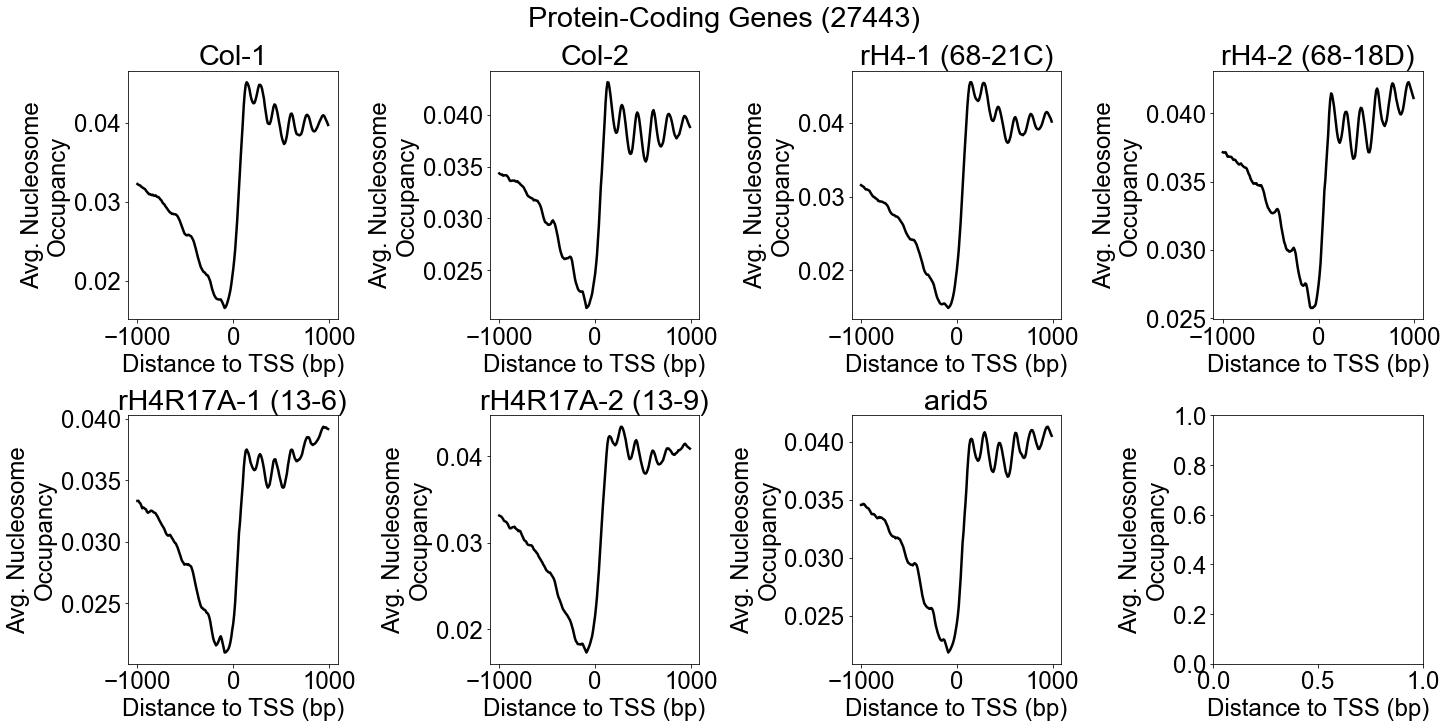

In [8]:
#Set font 
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 24})
plt.rcParams['lines.linewidth'] = 2.5

#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)/27443

#Split data by sample
Col_1_data = rowsum[0:200].tolist()
Col_2_data = rowsum[200:400].tolist()
x68_18D_data = rowsum[400:600].tolist()
x68_21C_data = rowsum[600:800].tolist()
x13_6_data = rowsum[800:1000].tolist()
x13_9_data = rowsum[1000:1200].tolist()
arid5_data = rowsum[1200:1400].tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 4, constrained_layout=True)
fig.set_size_inches(20, 10)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0, 0].plot(x_vals, Col_1_data, color="black")
axs[0, 0].set_title('Col-1')

axs[0, 1].plot(x_vals, Col_2_data, color="black")
axs[0, 1].set_title('Col-2')

axs[0, 2].plot(x_vals, x68_21C_data, color="black")
axs[0, 2].set_title('rH4-1 (68-21C)')

axs[0, 3].plot(x_vals, x68_18D_data, color="black")
axs[0, 3].set_title('rH4-2 (68-18D)')

axs[1, 0].plot(x_vals, x13_6_data, color="black")
axs[1, 0].set_title('rH4R17A-1 (13-6)')

axs[1, 1].plot(x_vals, x13_9_data, color="black")
axs[1, 1].set_title('rH4R17A-2 (13-9)')

axs[1, 2].plot(x_vals, arid5_data, color="black")
axs[1, 2].set_title('arid5')

fig.suptitle('Protein-Coding Genes (' + str(len(data_matrix)) + ")")
filename = "protein-coding_profiles/merged_all"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

### Selected Data

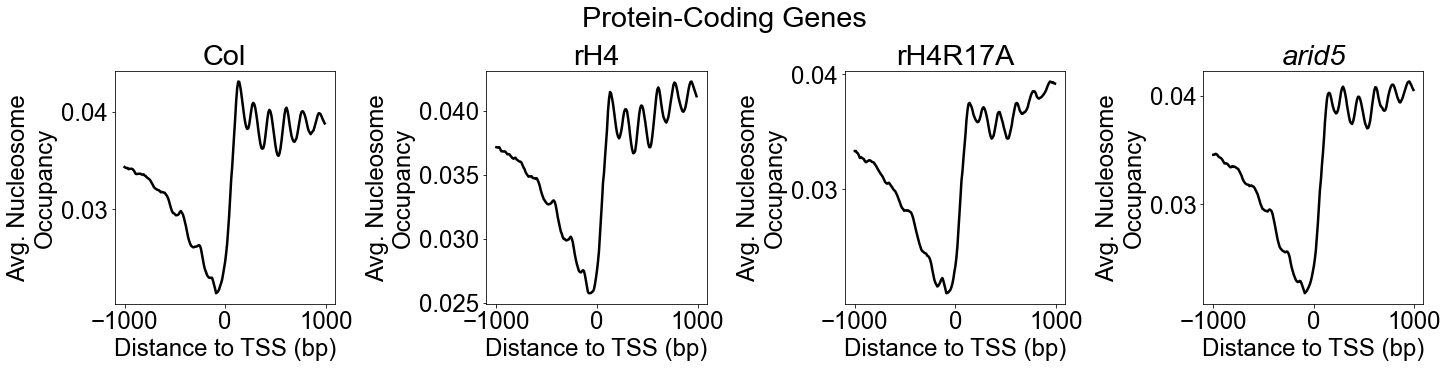

In [9]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#Plot data
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")

axs[0].plot(x_vals, Col_2_data, color="black")
axs[0].set_title('Col')

axs[1].plot(x_vals, x68_18D_data, color="black")
axs[1].set_title('rH4')

axs[2].plot(x_vals, x13_6_data, color="black")
axs[2].set_title('rH4R17A')

axs[3].plot(x_vals, arid5_data, color="black")
axs[3].set_title('arid5', style='italic')

fig.suptitle('Protein-Coding Genes')
filename = "protein-coding_profiles/merged_exp2_nonum"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

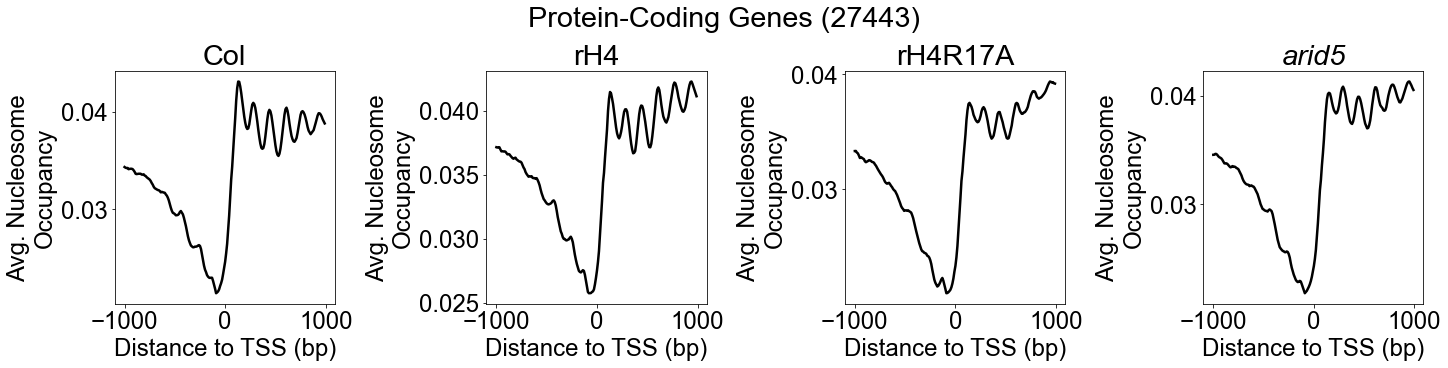

In [10]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#Plot data
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")

axs[0].plot(x_vals, Col_2_data, color="black")
axs[0].set_title('Col')

axs[1].plot(x_vals, x68_18D_data, color="black")
axs[1].set_title('rH4')

axs[2].plot(x_vals, x13_6_data, color="black")
axs[2].set_title('rH4R17A')

axs[3].plot(x_vals, arid5_data, color="black")
axs[3].set_title('arid5', style='italic')

fig.suptitle('Protein-Coding Genes (' + str(len(data_matrix)) + ")")
filename = "protein-coding_profiles/merged_exp2"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

## Combine nucleosome positioning data with expression data from RNA-seq

In [11]:
# Subset data to only include protein coding genes (Chr1-5)
# Load protein coding gene annotation file
base_path = "/Users/emmacorcoran/Desktop/annotations"
filename = "proteincoding_1to5.txt"
path_to_file = os.path.join(base_path, filename)
proteincoding_list = pd.read_csv(path_to_file, sep='\t', header=None)
proteincoding_list.columns = ['gene name','classification']

In [12]:
# Merge metadata with protein coding list
metadata = pd.merge(metadata, proteincoding_list, on="gene name")
metadata.head()

Col-1.mnase-fcnorm  Col-1.mnase-fcnorm.1  Col-1.mnase-fcnorm.2  \
0            0.000000              0.006271              0.009406   
1            0.000000              0.000000              0.000000   
2            0.013830              0.018440              0.015860   
3            0.007377              0.012170              0.017150   
4            0.043900              0.038360              0.045920   

   Col-1.mnase-fcnorm.3  Col-1.mnase-fcnorm.4  Col-1.mnase-fcnorm.5  \
0               0.03043              0.040020              0.037070   
1               0.00000              0.000000              0.000000   
2               0.01107              0.004611              0.000000   
3               0.01660              0.011070              0.009406   
4               0.06308              0.078200              0.075430   

   Col-1.mnase-fcnorm.6  Col-1.mnase-fcnorm.7  Col-1.mnase-fcnorm.8  \
0              0.034860              0.013830              0.007746   
1              0.000000              0.000000              0.000000   
2              0.000000              0.004058              0.007377   
3              0.005902              0.011800              0.020660   
4              0.083180              0.067500              0.046660   

   Col-1.mnase-fcnorm.9  ...  arid5.mnase-fcnorm.192  arid5.mnase-fcnorm.193  \
0              0.008669  ...                 0.12510                 0.06913   
1              0.000000  ...                 0.02327                 0.02144   
2              0.007377  ...                 0.05983                 0.05949   
3              0.034310  ...                 0.06631                 0.06182   
4              0.047400  ...                 0.01329                 0.01163   

   arid5.mnase-fcnorm.194  arid5.mnase-fcnorm.195  arid5.mnase-fcnorm.196  \
0                0.081100                0.064480                0.041880   
1                0.012630                0.009473                0.009971   
2                0.038720                0.015620                0.005318   
3                0.027090                0.016780                0.015290   
4                0.006647                0.005484                0.008309   

   arid5.mnase-fcnorm.197  arid5.mnase-fcnorm.198  arid5.mnase-fcnorm.199  \
0                 0.03656                0.007478                0.003324   
1                 0.00698                0.003324                0.000499   
2                 0.01695                0.025260                0.036390   
3                 0.01895                0.018950                0.051520   
4                 0.01778                0.036060                0.041210   

   gene name  classification  
0  AT1G01010  protein_coding  
1  AT1G01020  protein_coding  
2  AT1G01030  protein_coding  
3  AT1G01040  protein_coding  
4  AT1G01050  protein_coding  

[5 rows x 1402 columns]

In [13]:
#Load RNA-seq tpm expression data
def rnaseq_load(path):
    tpm_file = pd.read_csv(path, sep='\t', header=0)
    tpm_file.columns = ['gene name','rep1','rep2']
    tpm_file['avg'] = tpm_file[['rep1', 'rep2']].mean(axis=1)
    tpm_file = tpm_file.sort_values(by=['gene name'])
    return tpm_file

In [14]:
base_path_1 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"
base_path_2 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_05_21 RNA-seq/tpm/ordered_tpm_avg/"
base_path_3 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_07_08 RNA-seq/tpm/ordered_tpm_avg/"
base_path_4 = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_09_16 RNA-seq/tpm/ordered_tpm_avg/"

#Load Col expression data
filename = "Col_ordered_tpm.txt"
path_to_file = os.path.join(base_path_1, filename)
Col_tpm = rnaseq_load(path_to_file)

#Load rH4-1 (68-21C) expression data
filename = "68-21C_ordered_tpm.txt"
path_to_file = os.path.join(base_path_1, filename)
x68_21C_tpm = rnaseq_load(path_to_file)

#Load rH4-2 (68-18D) expression data
filename = "x68_18D_ordered_tpm.txt"
path_to_file = os.path.join(base_path_4, filename)
x68_18D_tpm = rnaseq_load(path_to_file)

#Load H4R17A-1 (13-6) expression data
filename = "13-6_ordered_tpm.txt"
path_to_file = os.path.join(base_path_2, filename)
x13_6_tpm = rnaseq_load(path_to_file)

#Load H4R17A-2 (13-9) expression data
filename = "13-9_ordered_tpm.txt"
path_to_file = os.path.join(base_path_1, filename)
x13_9_tpm = rnaseq_load(path_to_file)

#Load arid5 expression data
filename = "arid5_ordered_tpm.txt"
path_to_file = os.path.join(base_path_2, filename)
arid5_tpm = rnaseq_load(path_to_file)

#Load rlt1/2 expression data
filename = "rlt12_ordered_tpm.txt"
path_to_file = os.path.join(base_path_3, filename)
rlt12_tpm = rnaseq_load(path_to_file)

In [15]:
#Merge metadata with tpm expression data and subset for one sample, plot expression groups
def rowsum_tpm(all_data, tpm_label):
    tpm_data = all_data.loc[all_data['expression category'] == tpm_label]
    tpm_data = tpm_data.iloc[:,0:200]
    nrow = tpm_data.shape[0]
    tpm_rowsum = np.array(tpm_data.sum(axis=0))/nrow
    return tpm_rowsum

In [16]:
def tpm_expression_4groups(metadata_df, tpm_data, sample_colstart, sample_colend, name, italics=False):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=2.5)
    print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
    medhigh_tpm = ((subset_data['expression']>=0.5) & (subset_data['expression']<2.5))
    print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
    medlow_tpm = ((subset_data['expression']>0) & (subset_data['expression']<0.5))
    print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
    low_tpm = (subset_data['expression']==0)
    print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "very high"
    subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
    subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
    subset_data.loc[low_tpm==True, ['expression category']] = "very low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "very high")
    medhigh_rowsum = rowsum_tpm(subset_data, "high")
    medlow_rowsum = rowsum_tpm(subset_data, "low")
    low_rowsum = rowsum_tpm(subset_data, "very low")
    
    #Produce nucleosome occupancy plots of tpm expression groups (labeled with number of genes)
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(20, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
    axs[3].plot(x_vals, high_rowsum, '#bc202b')
    axs[3].set_title('Very High (' + str(np.count_nonzero(high_tpm)) + ')')
    axs[2].plot(x_vals, medhigh_rowsum, '#d16035')
    axs[2].set_title("High (" + str(np.count_nonzero(medhigh_tpm)) + ')')
    axs[1].plot(x_vals, medlow_rowsum, '#79b342')
    axs[1].set_title("Low (" + str(np.count_nonzero(medlow_tpm)) + ')')
    axs[0].plot(x_vals, low_rowsum, '#27aae1')
    axs[0].set_title("Very Low (" + str(np.count_nonzero(low_tpm)) + ')')
    
    if italics==True:
        fig.suptitle(name, style='italic')
    else:
        fig.suptitle(name)
    filename = "tpm_profiles_4groups/numbers_merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")
    
    #Produce nucleosome occupancy plots of tpm expression groups (not labeled with number of genes)
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(20, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
    axs[3].plot(x_vals, high_rowsum, '#bc202b')
    axs[3].set_title('Very High')
    axs[2].plot(x_vals, medhigh_rowsum, '#d16035')
    axs[2].set_title("High")
    axs[1].plot(x_vals, medlow_rowsum, '#79b342')
    axs[1].set_title("Low")
    axs[0].plot(x_vals, low_rowsum, '#27aae1')
    axs[0].set_title("Very Low")
    
    if italics==True:
        fig.suptitle(name, style='italic')
    else:
        fig.suptitle(name)
    filename = "tpm_profiles_4groups/merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")
    
    return subset_data

In [17]:
def tpm_expression_2groups(metadata_df, tpm_data, sample_colstart, sample_colend, name, italics=False):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=0.5)
    print('High expression: ' + str(np.count_nonzero(high_tpm)))
    low_tpm = (subset_data['expression']<0.5)
    print('Low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "high"
    subset_data.loc[low_tpm==True, ['expression category']] = "low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "high")
    low_rowsum = rowsum_tpm(subset_data, "low")
    
    #Produce nucleosome occupancy plots of tpm expression groups (with number of genes)
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
    axs[1].plot(x_vals, high_rowsum, color='#bc202b')
    axs[1].set_title("High (" + str(np.count_nonzero(high_tpm)) + ')')
    axs[0].plot(x_vals, low_rowsum, color='#27aae1')
    axs[0].set_title("Low (" + str(np.count_nonzero(low_tpm)) + ')')
    
    if italics==True:
        fig.suptitle(name, style='italic')
    else:
        fig.suptitle(name)
        
    filename = "tpm_profiles_2groups/numbers_merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")
    
    #Produce nucleosome occupancy plots of tpm expression groups
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
    axs[1].plot(x_vals, high_rowsum, color='#bc202b')
    axs[1].set_title("High")
    axs[0].plot(x_vals, low_rowsum, color='#27aae1')
    axs[0].set_title("Low")
    
    if italics==True:
        fig.suptitle(name, style='italic')
    else:
        fig.suptitle(name)
    filename = "tpm_profiles_2groups/merged_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")
    
    return subset_data

Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
High expression: 15617
Low expression: 11826


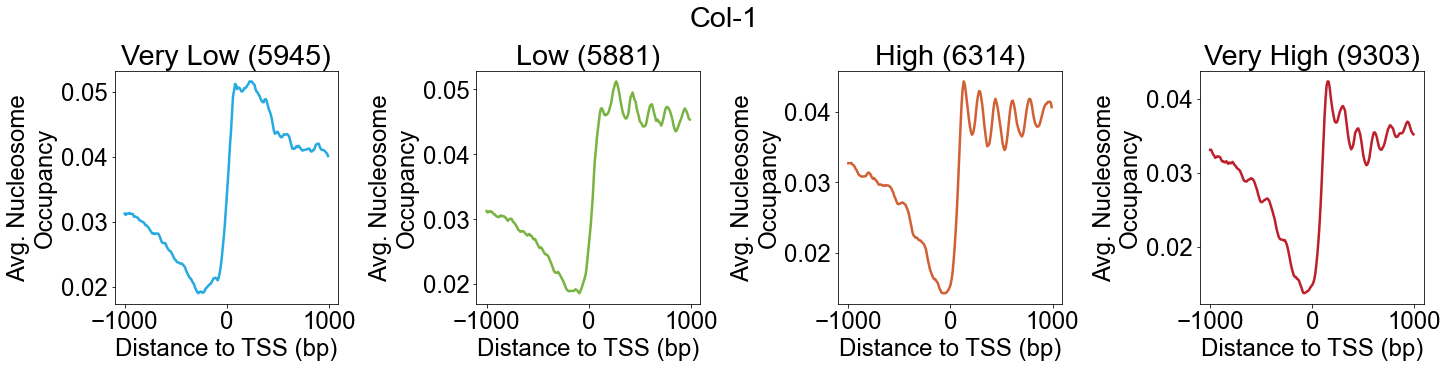

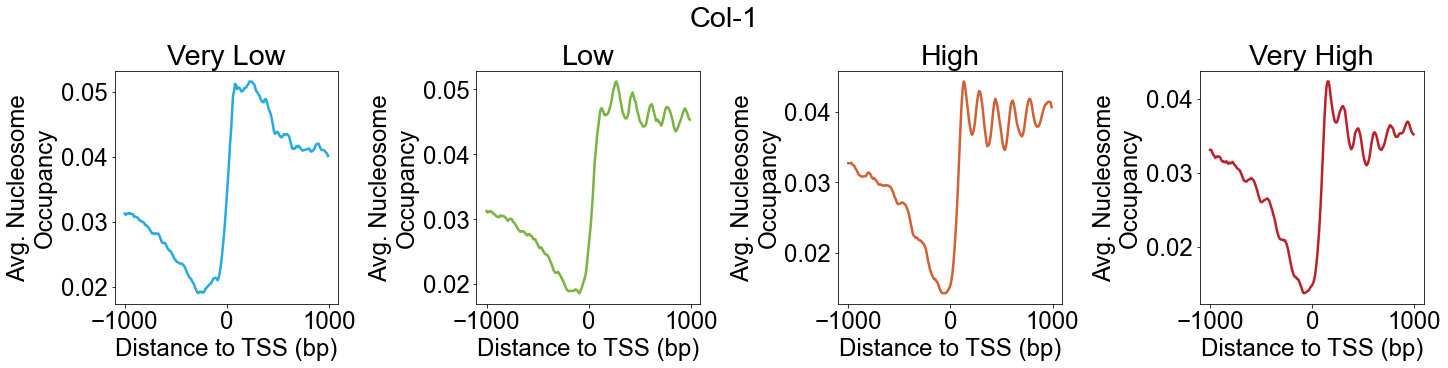

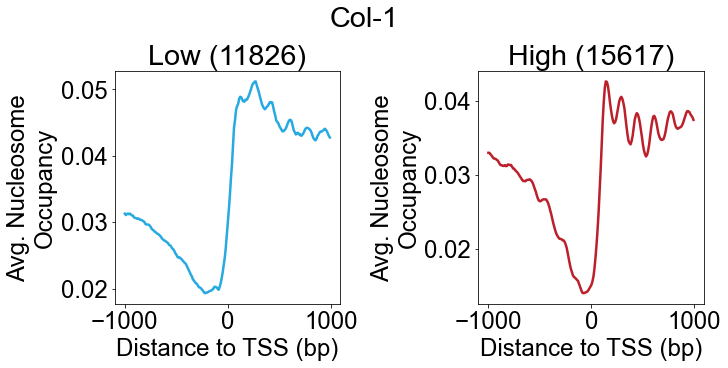

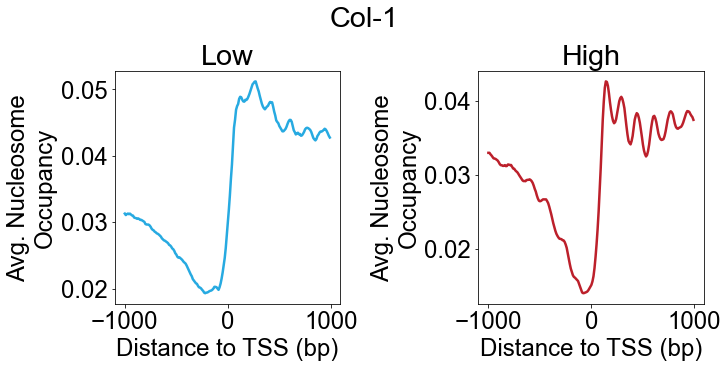

In [18]:
Col_1_4subset = tpm_expression_4groups(metadata, Col_tpm, "Col-1.mnase-fcnorm","Col-1.mnase-fcnorm.199", "Col-1")
Col_1_2subset = tpm_expression_2groups(metadata, Col_tpm, "Col-1.mnase-fcnorm","Col-1.mnase-fcnorm.199", "Col-1")

Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
High expression: 15617
Low expression: 11826


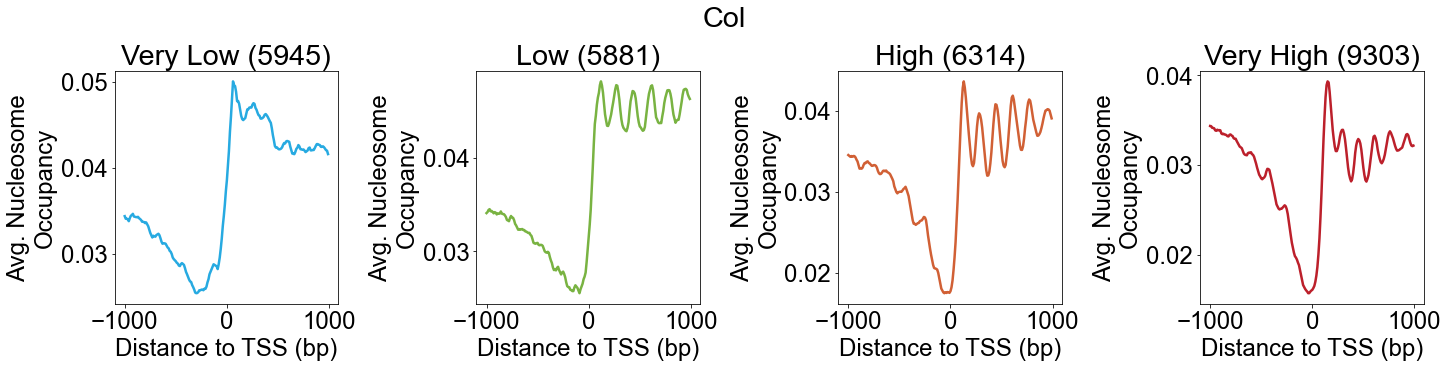

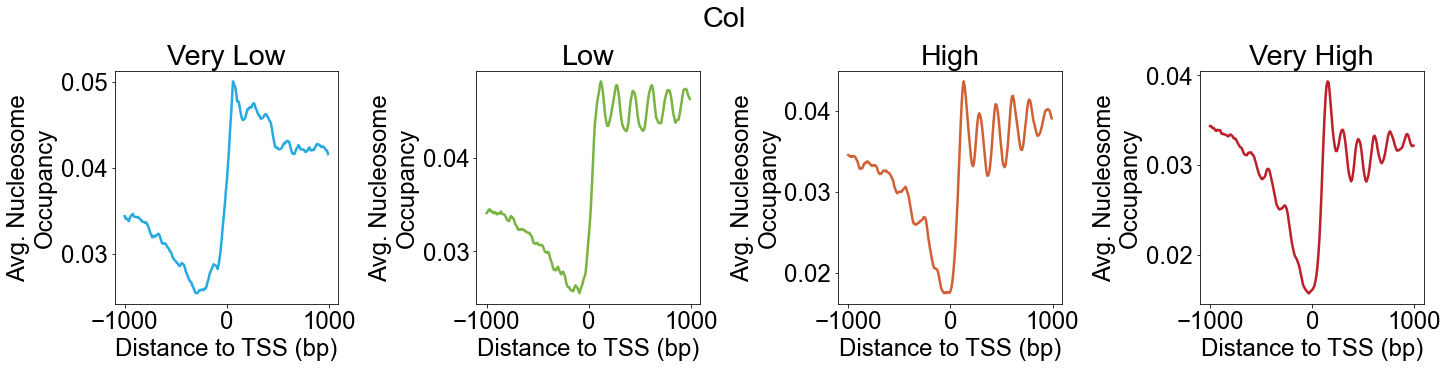

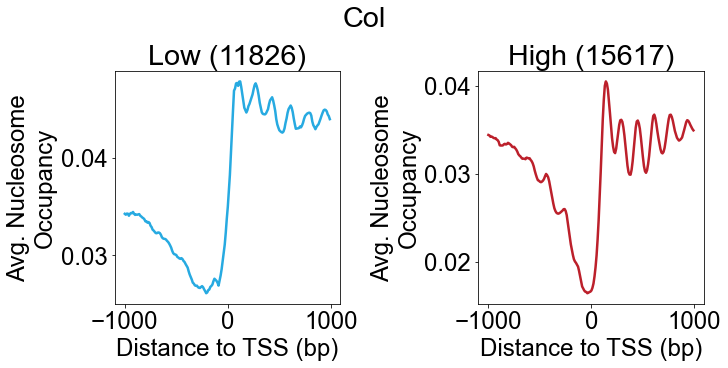

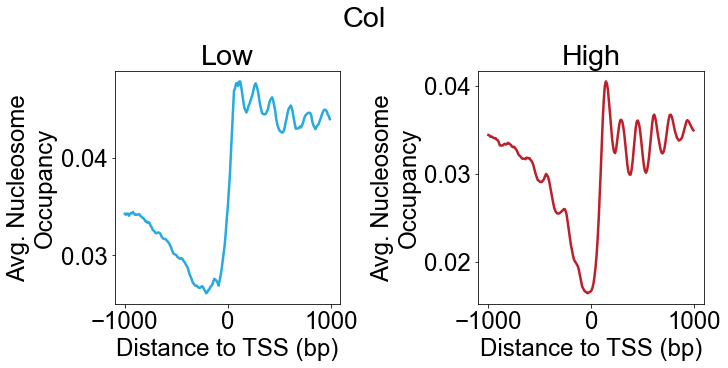

In [19]:
Col_2_4subset = tpm_expression_4groups(metadata, Col_tpm, "Col-2.mnase-fcnorm","Col-2.mnase-fcnorm.199", "Col")
Col_2_2subset = tpm_expression_2groups(metadata, Col_tpm, "Col-2.mnase-fcnorm","Col-2.mnase-fcnorm.199", "Col")

Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
High expression: 14232
Low expression: 13211


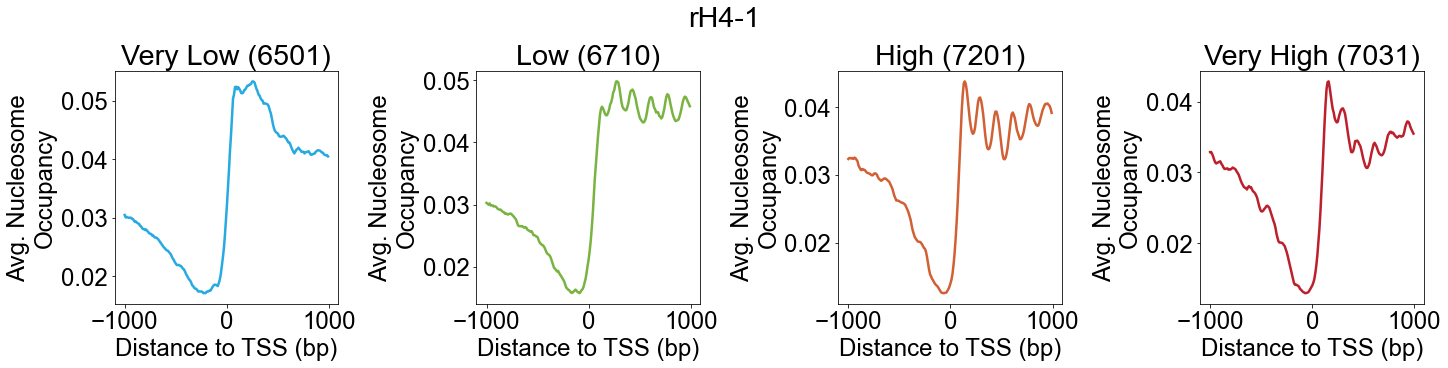

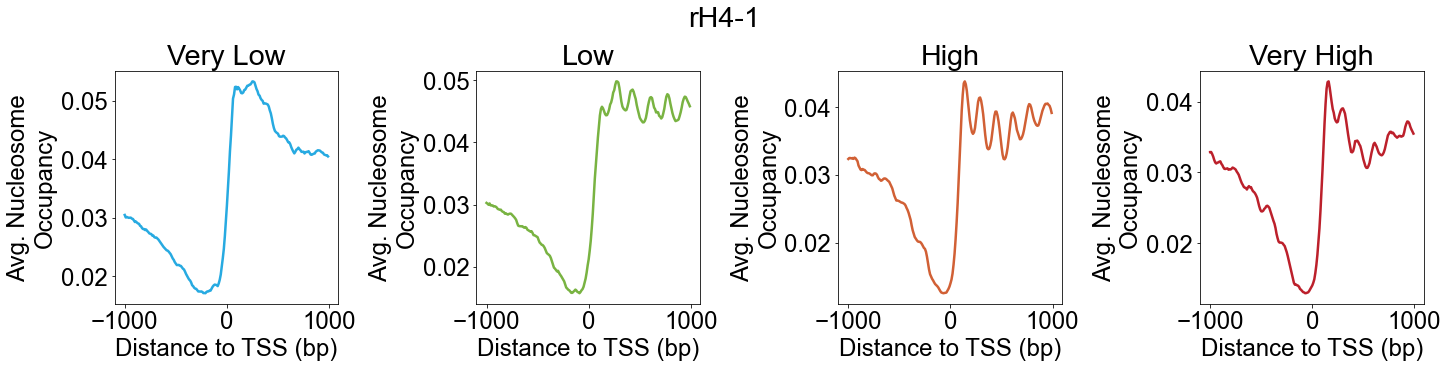

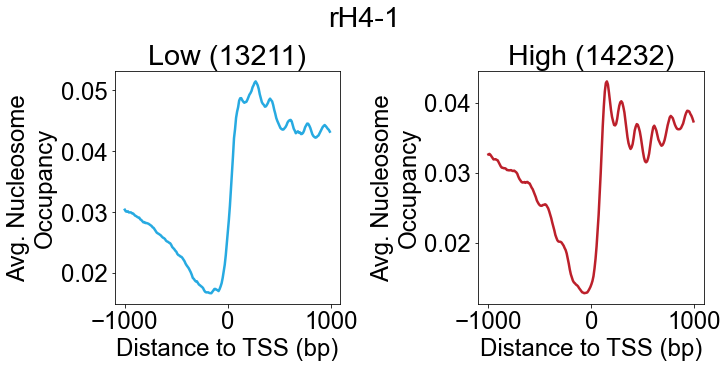

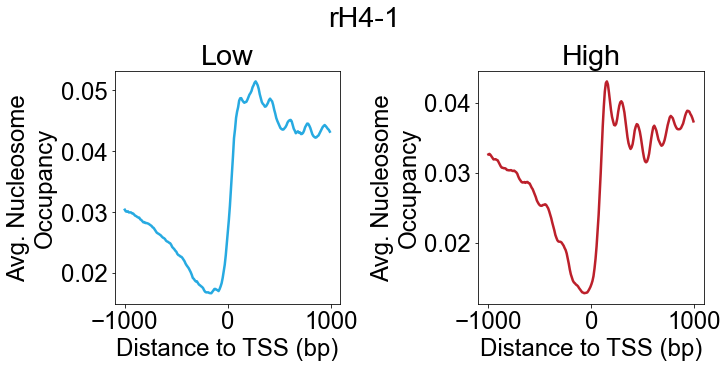

In [20]:
x68_21C_4subset = tpm_expression_4groups(metadata, x68_21C_tpm, "68-21C.mnase-fcnorm","68-21C.mnase-fcnorm.199", "rH4-1")
x68_21C_2subset = tpm_expression_2groups(metadata, x68_21C_tpm, "68-21C.mnase-fcnorm","68-21C.mnase-fcnorm.199", "rH4-1")

Very high expression: 8667
High expression: 6671
Low expression: 6541
Very low expression: 5564
High expression: 15338
Low expression: 12105


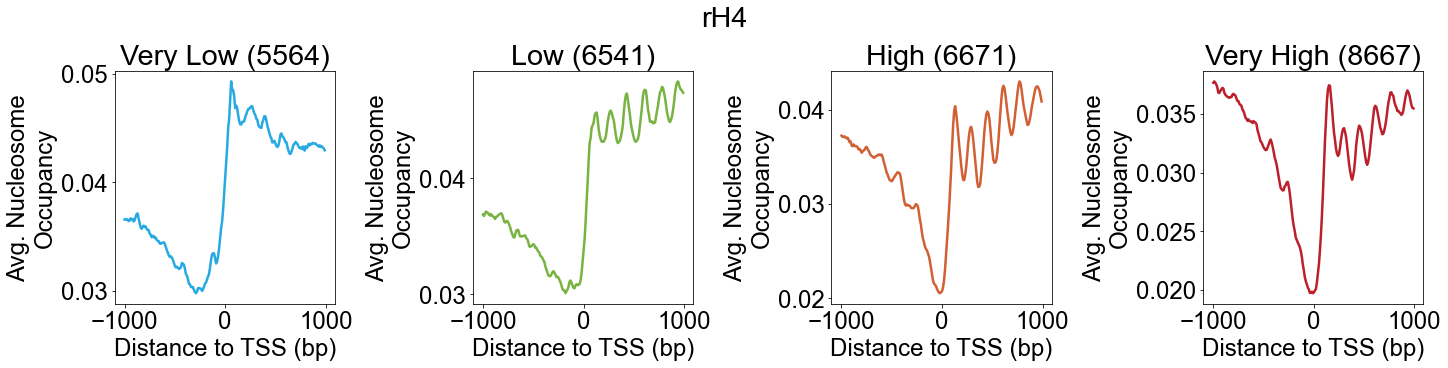

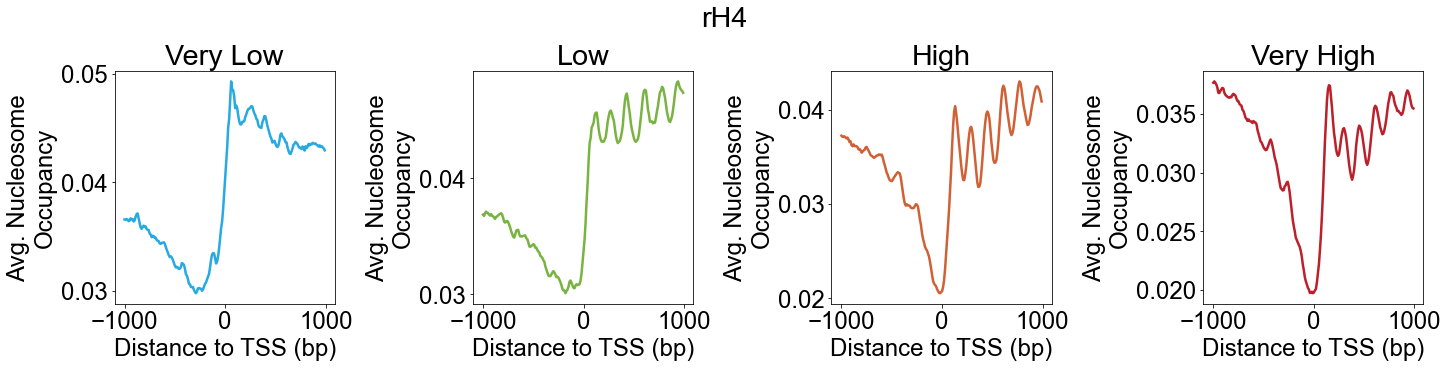

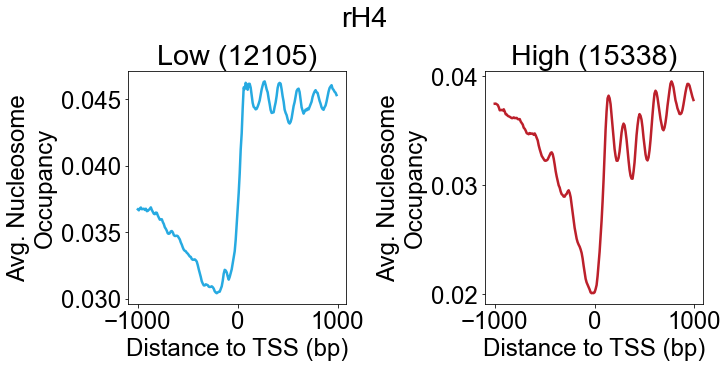

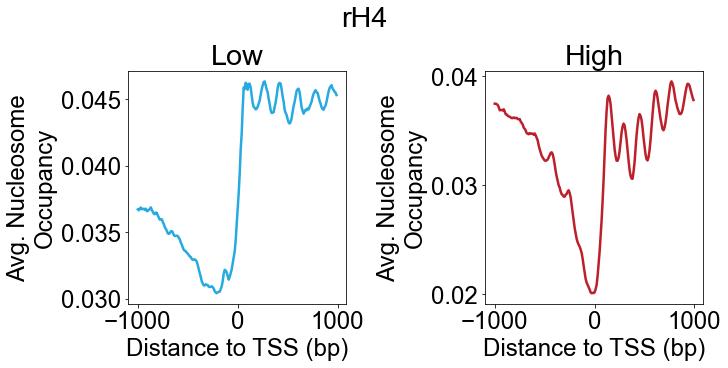

In [21]:
x68_18D_4subset = tpm_expression_4groups(metadata, x68_18D_tpm, "68-18D.mnase-fcnorm","68-18D.mnase-fcnorm.199", "rH4")
x68_18D_2subset = tpm_expression_2groups(metadata, x68_18D_tpm, "68-18D.mnase-fcnorm","68-18D.mnase-fcnorm.199", "rH4")

Very high expression: 8410
High expression: 6476
Low expression: 6337
Very low expression: 6220
High expression: 14886
Low expression: 12557


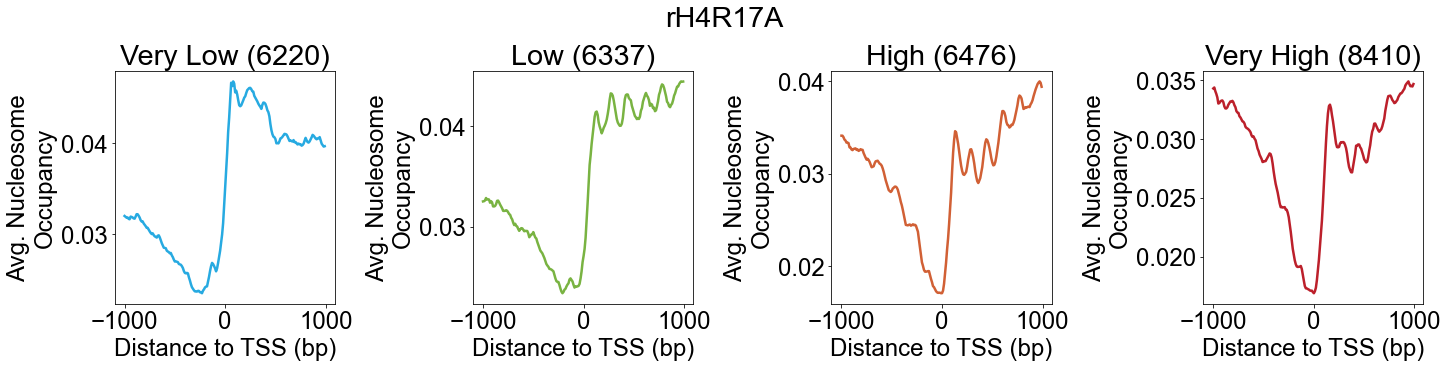

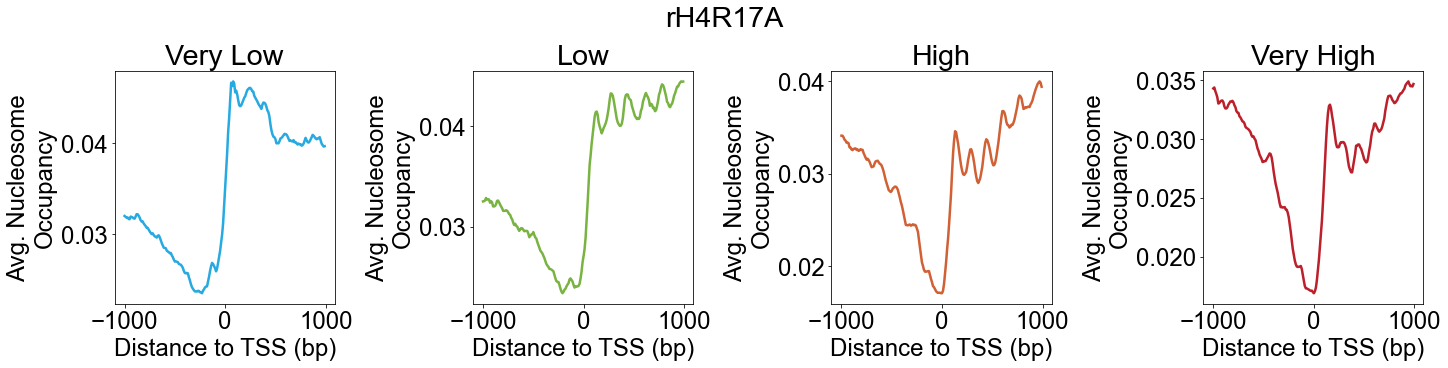

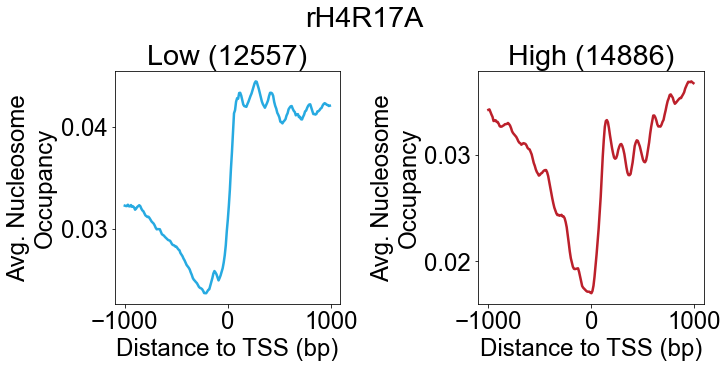

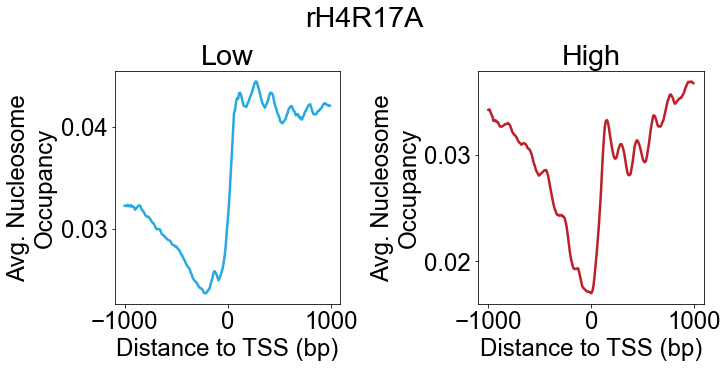

In [22]:
x13_6_4subset = tpm_expression_4groups(metadata, x13_6_tpm, "13-6.mnase-fcnorm","13-6.mnase-fcnorm.199", "rH4R17A")
x13_6_2subset = tpm_expression_2groups(metadata, x13_6_tpm, "13-6.mnase-fcnorm","13-6.mnase-fcnorm.199", "rH4R17A")

Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
High expression: 15217
Low expression: 12226


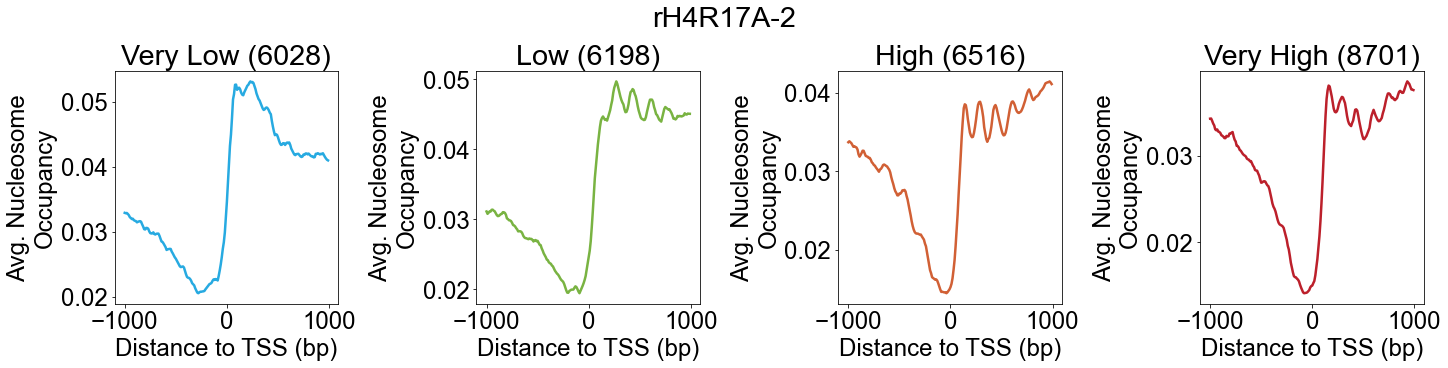

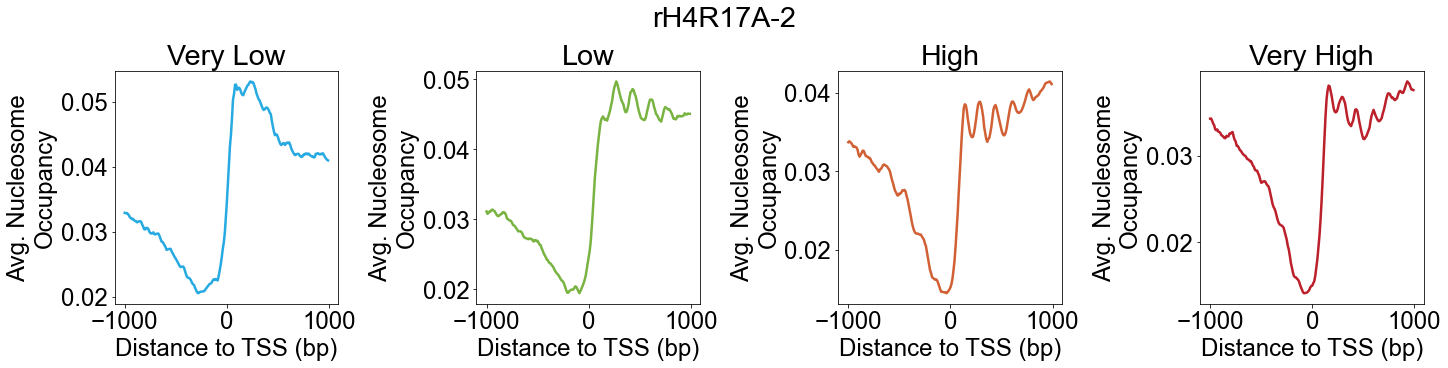

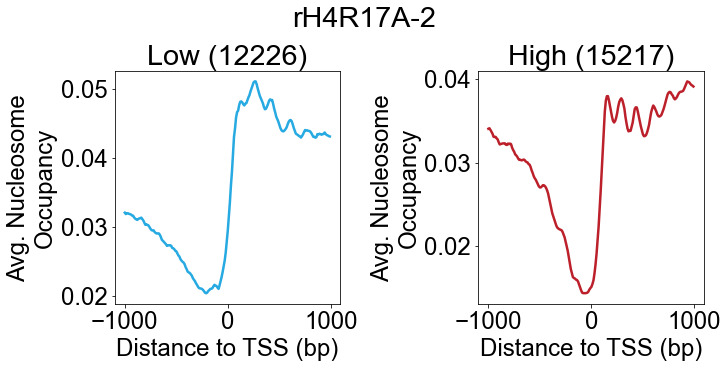

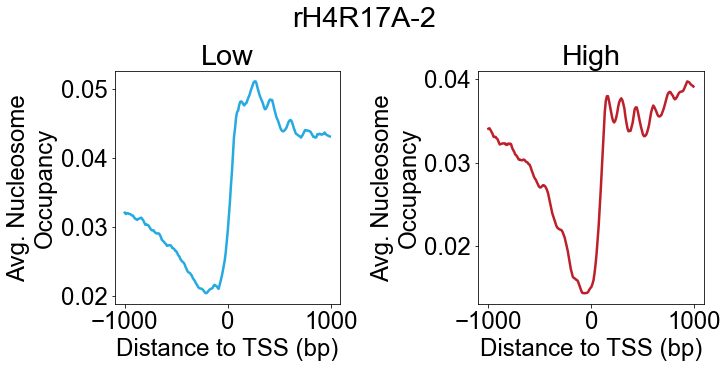

In [23]:
x13_9_4subset = tpm_expression_4groups(metadata, x13_9_tpm, "13-9.mnase-fcnorm","13-9.mnase-fcnorm.199", "rH4R17A-2")
x13_9_2subset = tpm_expression_2groups(metadata, x13_9_tpm, "13-9.mnase-fcnorm","13-9.mnase-fcnorm.199", "rH4R17A-2")

Very high expression: 9656
High expression: 5672
Low expression: 6150
Very low expression: 5965
High expression: 15328
Low expression: 12115


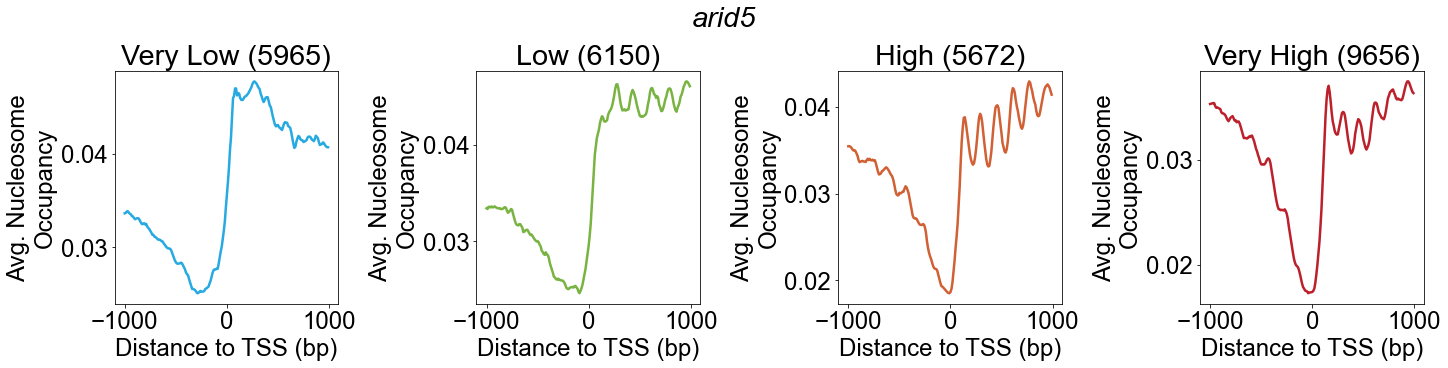

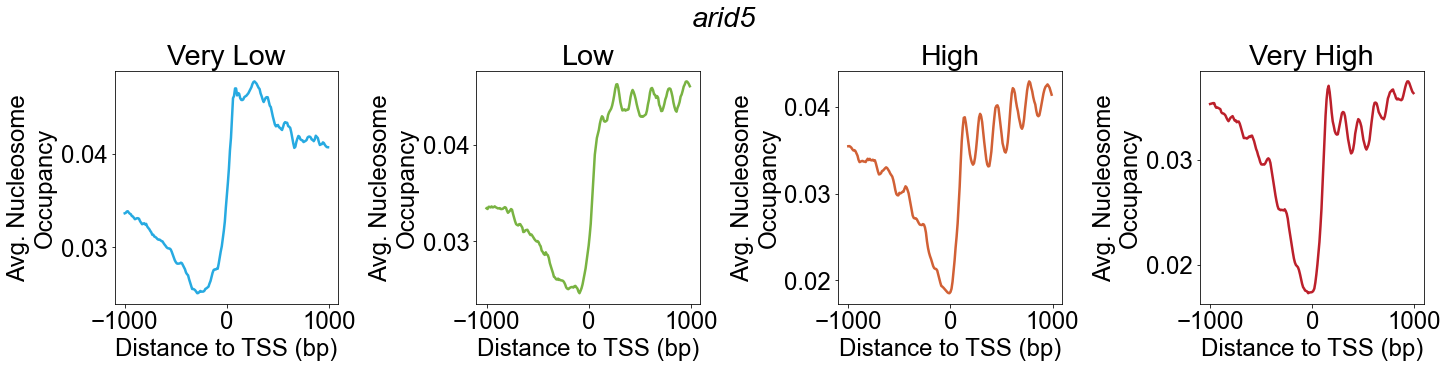

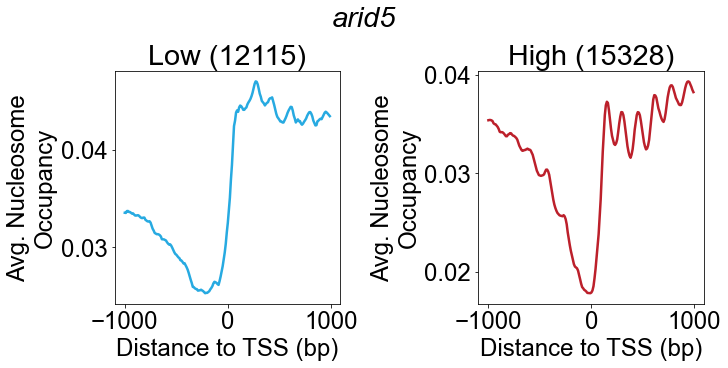

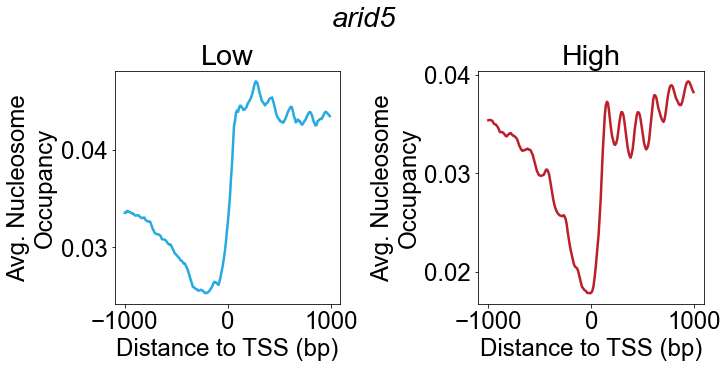

In [24]:
arid5_4subset = tpm_expression_4groups(metadata, arid5_tpm, "arid5.mnase-fcnorm","arid5.mnase-fcnorm.199", "arid5", italics=True)
arid5_2subset = tpm_expression_2groups(metadata, arid5_tpm, "arid5.mnase-fcnorm","arid5.mnase-fcnorm.199", "arid5", italics=True)

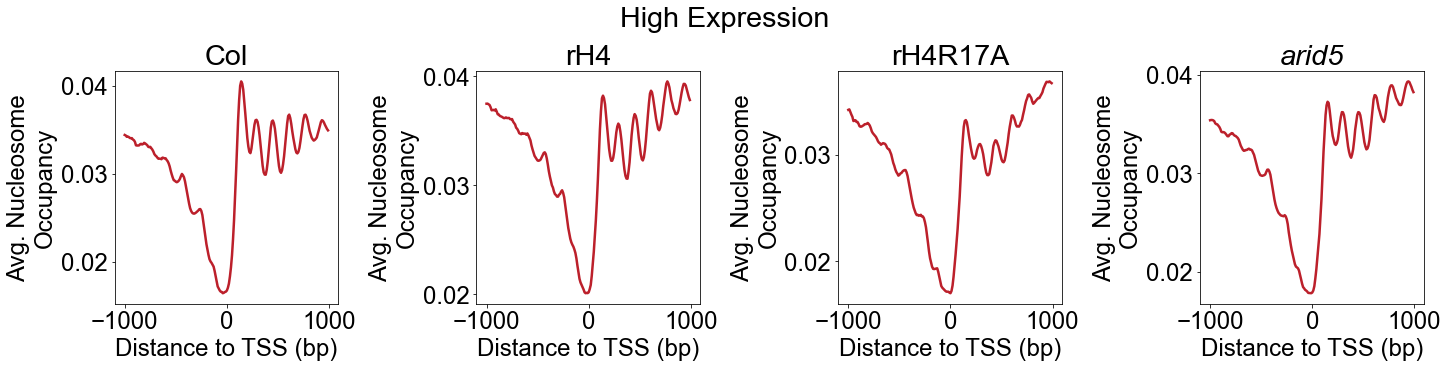

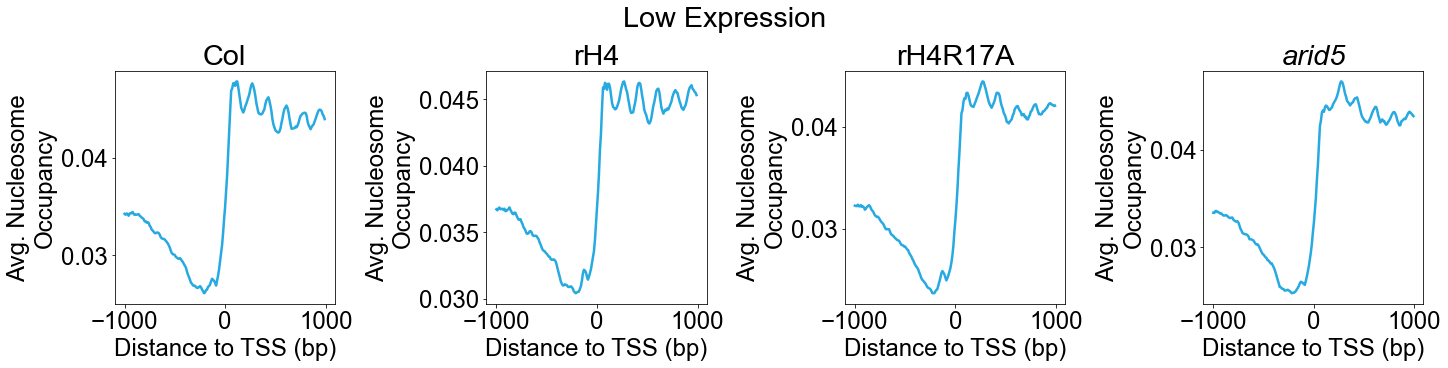

In [25]:
# Plot all groups of genes separated by expression level together

#Produce nucleosome occupancy plots of highly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_2subset, "high"), '#bc202b')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_2subset, "high"), '#bc202b')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_2subset, "high"), '#bc202b')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_2subset, "high"), '#bc202b')
axs[3].set_title('arid5', style='italic')
fig.suptitle("High Expression")
filename = "tpm_profiles_bygenotype/2groups_high"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

#Produce nucleosome occupancy plots of lowly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_2subset, "low"), '#27aae1')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_2subset, "low"), '#27aae1')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_2subset, "low"), '#27aae1')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_2subset, "low"), '#27aae1')
axs[3].set_title('arid5', style='italic')
fig.suptitle("Low Expression")
filename = "tpm_profiles_bygenotype/2groups_low"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

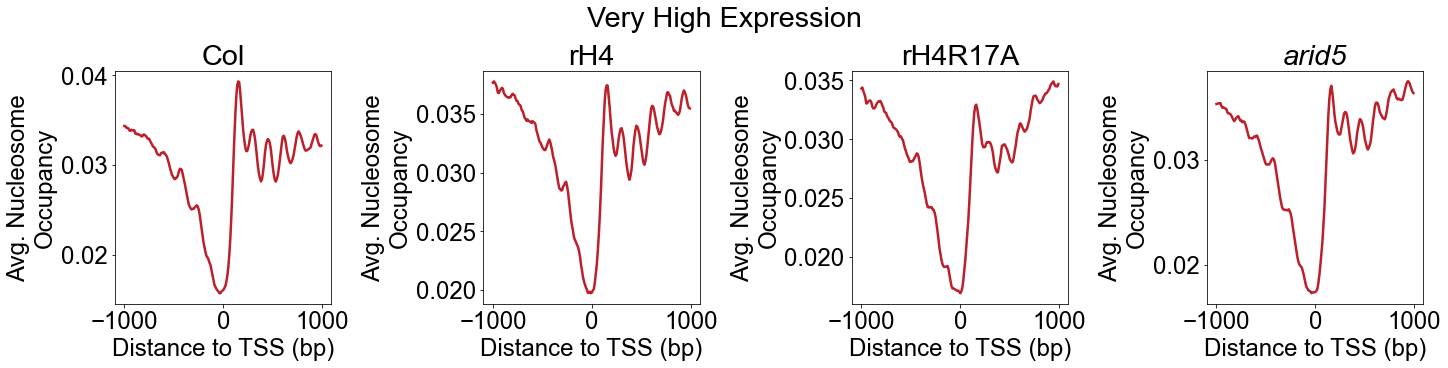

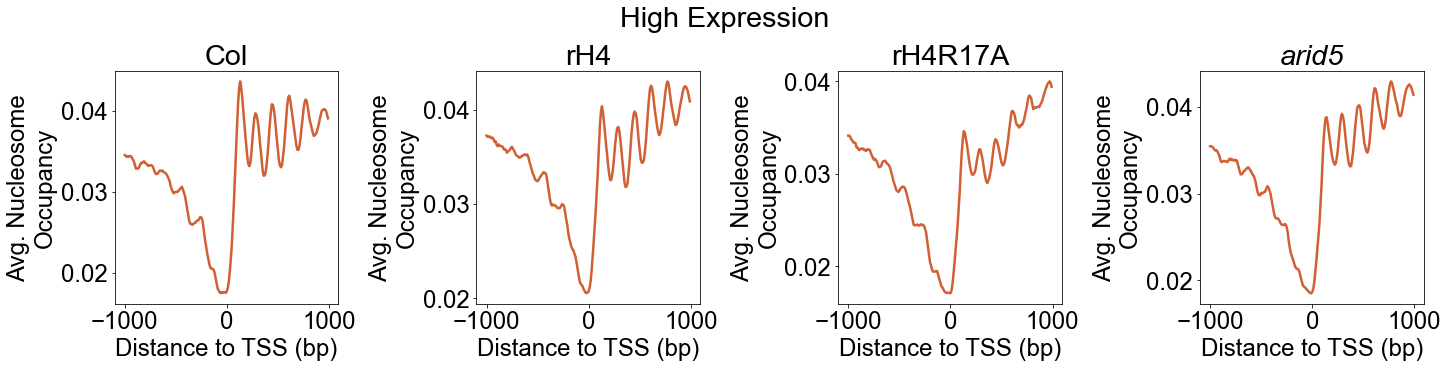

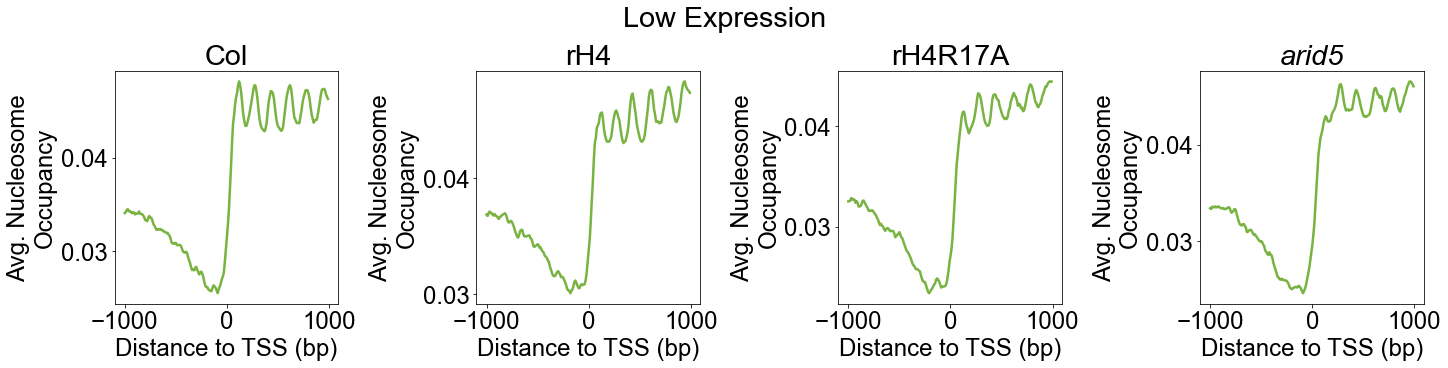

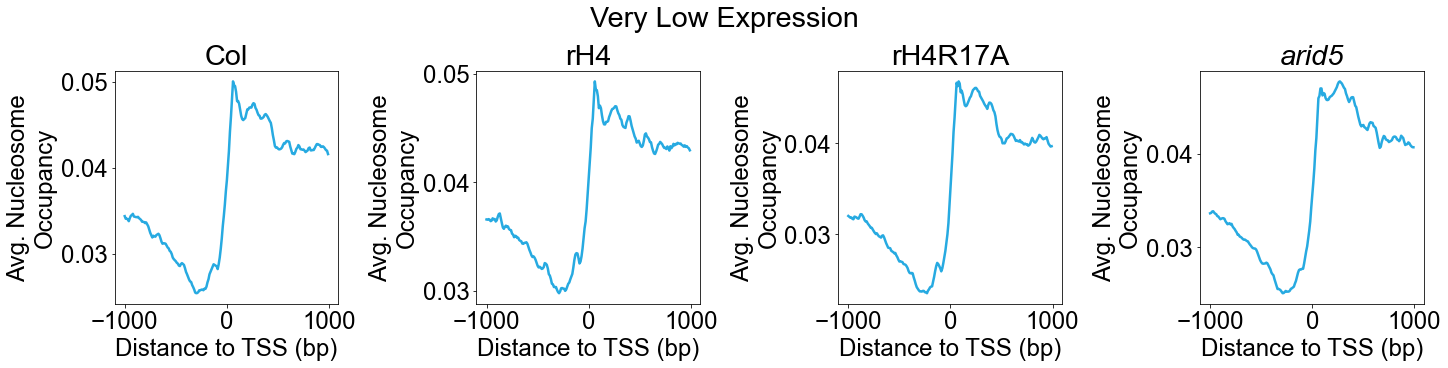

In [26]:
# Plot all groups of genes separated by expression level together

#Produce nucleosome occupancy plots of very highly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_4subset, "very high"), '#bc202b')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_4subset, "very high"), '#bc202b')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_4subset, "very high"), '#bc202b')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_4subset, "very high"), '#bc202b')
axs[3].set_title('arid5', style='italic')
fig.suptitle("Very High Expression")
filename = "tpm_profiles_bygenotype/very_high"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

#Produce nucleosome occupancy plots of highly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_4subset, "high"), '#d16035')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_4subset, "high"), '#d16035')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_4subset, "high"), '#d16035')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_4subset, "high"), '#d16035')
axs[3].set_title('arid5', style='italic')
fig.suptitle("High Expression")
filename = "tpm_profiles_bygenotype/high"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

#Produce nucleosome occupancy plots of lowly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_4subset, "low"), '#79b342')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_4subset, "low"), '#79b342')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_4subset, "low"), '#79b342')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_4subset, "low"), '#79b342')
axs[3].set_title('arid5', style='italic')
fig.suptitle("Low Expression")
filename = "tpm_profiles_bygenotype/low"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

#Produce nucleosome occupancy plots of very lowly expressed genes
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(20, 5)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")
axs[0].plot(x_vals, rowsum_tpm(Col_2_4subset, "very low"), '#27aae1')
axs[0].set_title('Col')
axs[1].plot(x_vals, rowsum_tpm(x68_18D_4subset, "very low"), '#27aae1')
axs[1].set_title('rH4')
axs[2].plot(x_vals, rowsum_tpm(x13_6_4subset, "very low"), '#27aae1')
axs[2].set_title('rH4R17A')
axs[3].plot(x_vals, rowsum_tpm(arid5_4subset, "very low"), '#27aae1')
axs[3].set_title('arid5', style='italic')
fig.suptitle("Very Low Expression")
filename = "tpm_profiles_bygenotype/very_low"
path_to_file = os.path.join(save_path, filename)
plt.savefig(path_to_file+".pdf")

In [27]:
# Load DEG data
def deg_load(path, name):
    deg_file = pd.read_csv(path_to_file, sep='\t', header=None)
    deg_file.columns = [name]
    return deg_file

base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_09_16 RNA-seq/Up_and_Down"

#chr11/17 down-regulated genes
filename = "chr11chr17_downreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_downreg = deg_load(path_to_file, "gene name")
#chr11/17 up-regulated genes
filename = "chr11chr17_upreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_upreg = deg_load(path_to_file, "gene name")

#R17A-2 down-regulated genes
filename = "13.9_downreg.txt"
path_to_file = os.path.join(base_path, filename)
x13_9_downreg = deg_load(path_to_file, "gene name")
#R17A-2 up-regulated genes
filename = "13.9_downreg.txt"
path_to_file = os.path.join(base_path, filename)
x13_9_upreg = deg_load(path_to_file, "gene name")

#R17A-1 down-regulated genes
filename = "13.6_downreg.txt"
path_to_file = os.path.join(base_path, filename)
x13_6_downreg = deg_load(path_to_file, "gene name")
#R17A-1 up-regulated genes
filename = "13.6_downreg.txt"
path_to_file = os.path.join(base_path, filename)
x13_6_upreg = deg_load(path_to_file, "gene name")

#arid5 down-regulated genes
filename = "arid5_downreg.txt"
path_to_file = os.path.join(base_path, filename)
arid5_downreg = deg_load(path_to_file, "gene name")
#arid5 up-regulated genes
filename = "arid5_upreg.txt"
path_to_file = os.path.join(base_path, filename)
arid5_upreg = deg_load(path_to_file, "gene name")

#rlt1/2 down-regulated genes
filename = "rlt12_downreg.txt"
path_to_file = os.path.join(base_path, filename)
rlt12_downreg = deg_load(path_to_file, "gene name")
#rlt1/2 up-regulated genes
filename = "rlt12_upreg.txt"
path_to_file = os.path.join(base_path, filename)
rlt12_upreg = deg_load(path_to_file, "gene name")

In [28]:
def merge_upanddown(metadata, downreg, upreg):
    downreg_subset = pd.merge(metadata, downreg, on="gene name")
    upreg_subset = pd.merge(metadata, upreg, on="gene name")
    upreg_subset['DEG'] = "up"
    downreg_subset['DEG'] = "down"
    deg_subset = downreg_subset.append(upreg_subset)
    return(deg_subset)

In [29]:
#Merge metadata with DEG data
chr_deg_subset = merge_upanddown(metadata, chr_downreg, chr_upreg)
arid5_deg_subset = merge_upanddown(metadata, arid5_downreg, arid5_upreg)
rlt12_deg_subset = merge_upanddown(metadata, rlt12_downreg, rlt12_upreg)
x13_6_deg_subset = merge_upanddown(metadata, x13_6_downreg, x13_6_upreg)
x13_9_deg_subset = merge_upanddown(metadata, x13_9_downreg, x13_9_upreg)

In [30]:
def merge_all(metadata, deg_1, deg_2, deg_3=None, deg_4=None, deg_5=None):
    all_deg = pd.merge(deg_1, deg_2, on="gene name", how="outer")
    if deg_3 is not None:
        all_deg = pd.merge(all_deg, deg_3, on="gene name", how="outer")
    if deg_4 is not None:
        all_deg = pd.merge(all_deg, deg_4, on="gene name", how="outer")
    if deg_5 is not None:
        all_deg = pd.merge(all_deg, deg_5, on="gene name", how="outer")
    deg_subset = pd.merge(metadata, all_deg, on="gene name")
    return(deg_subset)

In [31]:
chr_deg = pd.merge(chr_downreg, chr_upreg, how="outer")
arid5_deg = pd.merge(arid5_downreg, arid5_upreg, how="outer")
rlt12_deg = pd.merge(rlt12_downreg, rlt12_upreg, how="outer")
x13_6_deg = pd.merge(x13_6_downreg, x13_6_upreg, how="outer")
x13_9_deg = pd.merge(x13_9_downreg, x13_9_upreg, how="outer")
x13_deg = pd.merge(x13_6_deg, x13_9_deg, how="outer")

iswi_deg_subset = merge_all(metadata, chr_deg, arid5_deg, rlt12_deg)
all_deg_subset = merge_all(metadata, chr_deg, arid5_deg, rlt12_deg, x13_deg)
x13_deg_subset = merge_all(metadata, x13_6_deg, x13_9_deg)

In [32]:
#Unaffected genes
# Load DEG data
def deg_load(path, name):
    deg_file = pd.read_csv(path_to_file, sep='\t', header=None)
    deg_file.columns = [name]
    return deg_file

base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2021_09_16 RNA-seq/Unaffected"

#chr11/17 Unaffected genes
filename = "chrvsCol.txt"
path_to_file = os.path.join(base_path, filename)
chr_unaffected = deg_load(path_to_file, "gene name")

#arid5 Unaffected genes
filename = "arid5vsCol.txt"
path_to_file = os.path.join(base_path, filename)
arid5_unaffected = deg_load(path_to_file, "gene name")

#rlt1/2 Unaffected genes
filename = "rlt12vsCol.txt"
path_to_file = os.path.join(base_path, filename)
rlt12_unaffected = deg_load(path_to_file, "gene name")

#13.6 Unaffected genes
filename = "13.6vsCol.txt"
path_to_file = os.path.join(base_path, filename)
s13_6_unaffected = deg_load(path_to_file, "gene name")

#13.9 Unaffected genes
filename = "13.9vsCol.txt"
path_to_file = os.path.join(base_path, filename)
s13_9_unaffected = deg_load(path_to_file, "gene name")

In [33]:
def merge_unaffected(metadata, deg_1, deg_2, deg_3=None, deg_4=None, deg_5=None):
    all_deg = pd.merge(deg_1, deg_2, on="gene name", how="outer")
    if deg_3 is not None:
        all_deg = pd.merge(all_deg, deg_3, on="gene name", how="outer")
    if deg_4 is not None:
        all_deg = pd.merge(all_deg, deg_4, on="gene name", how="outer")
    if deg_5 is not None:
        all_deg = pd.merge(all_deg, deg_5, on="gene name", how="outer")
    deg_subset = pd.merge(metadata, all_deg, on="gene name")
    return(deg_subset)

In [34]:
chr_unaffected_subset = pd.merge(metadata, chr_unaffected, on="gene name")
rlt12_unaffected_subset = pd.merge(metadata, rlt12_unaffected, on="gene name")
arid5_unaffected_subset = pd.merge(metadata, arid5_unaffected, on="gene name")
s13_6_unaffected_subset = pd.merge(metadata, s13_6_unaffected, on="gene name")
s13_9_unaffected_subset = pd.merge(metadata, s13_9_unaffected, on="gene name")

x13_unaffected = pd.merge(s13_6_unaffected, s13_9_unaffected, how="outer")

iswi_unaffected_subset = merge_unaffected(metadata, chr_unaffected, arid5_unaffected, rlt12_unaffected)
all_unaffected_subset = merge_unaffected(metadata, chr_unaffected, arid5_unaffected, rlt12_unaffected, x13_unaffected)
x13_unaffected_subset = merge_unaffected(metadata, s13_6_unaffected, s13_9_unaffected)

In [35]:
def plot_gene_group_exp2(all_data, name, graph_col="black", deg=True):
    #Merge metadata with tpm expression data and subset for one sample
    if deg==True:
        subset_data = all_data.drop(['gene name', 'classification', 'DEG'],axis=1)
    else:
        subset_data = all_data.drop(['gene name', 'classification'],axis=1)
    #Sum rows
    nrow = all_data.shape[0]
    rowsum = np.array(subset_data.sum(axis=0))/nrow

    #Split data by sample
    Col_1_data = rowsum[0:200].tolist()
    Col_2_data = rowsum[200:400].tolist()
    x68_18D_data = rowsum[400:600].tolist()
    x68_21C_data = rowsum[600:800].tolist()
    x13_6_data = rowsum[800:1000].tolist()
    x13_9_data = rowsum[1000:1200].tolist()
    arid5_data = rowsum[1200:1400].tolist()

    #Plot data
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(20, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")

    axs[0].plot(x_vals, Col_2_data, color=graph_col)
    axs[0].set_title('Col')

    axs[1].plot(x_vals, x68_18D_data, color=graph_col)
    axs[1].set_title('rH4')

    axs[2].plot(x_vals, x13_6_data, color=graph_col)
    axs[2].set_title('rH4R17A')
    
    axs[3].plot(x_vals, arid5_data, color=graph_col)
    axs[3].set_title('arid5', style='italic')

    fig.suptitle(name + " (" + str(nrow) + ")")
    filename = "DEG_plots/merged_exp2_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")
    
    
    #Plot data with no numbers
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(20, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel="Avg. Nucleosome" "\n" "Occupancy")

    axs[0].plot(x_vals, Col_2_data, color=graph_col)
    axs[0].set_title('Col')

    axs[1].plot(x_vals, x68_18D_data, color=graph_col)
    axs[1].set_title('rH4')

    axs[2].plot(x_vals, x13_6_data, color=graph_col)
    axs[2].set_title('rH4R17A')
    
    axs[3].plot(x_vals, arid5_data, color=graph_col)
    axs[3].set_title('arid5', style='italic')

    fig.suptitle(name)
    filename = "DEG_plots/merged_exp2_nonum_"
    path_to_file = os.path.join(save_path, filename)
    plt.savefig(path_to_file+name+".pdf")

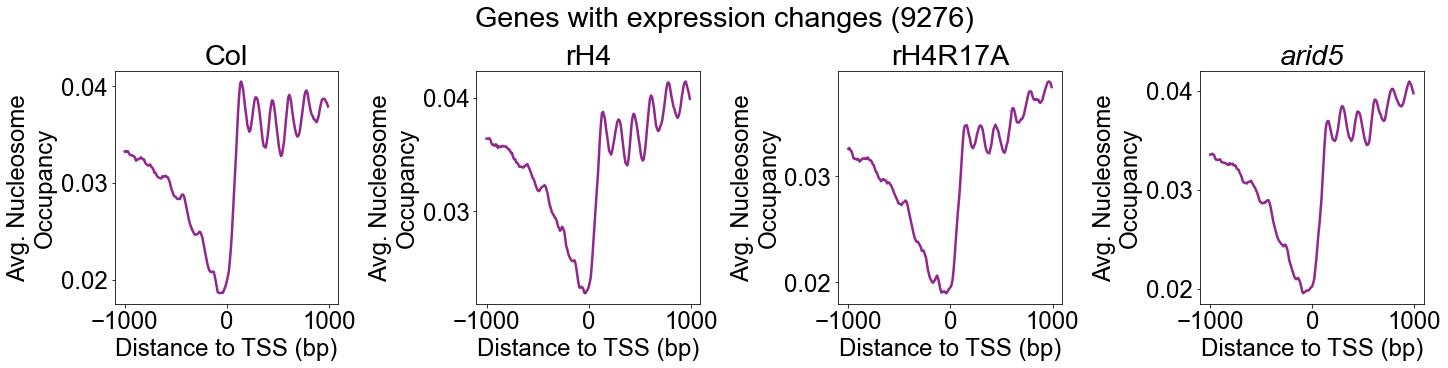

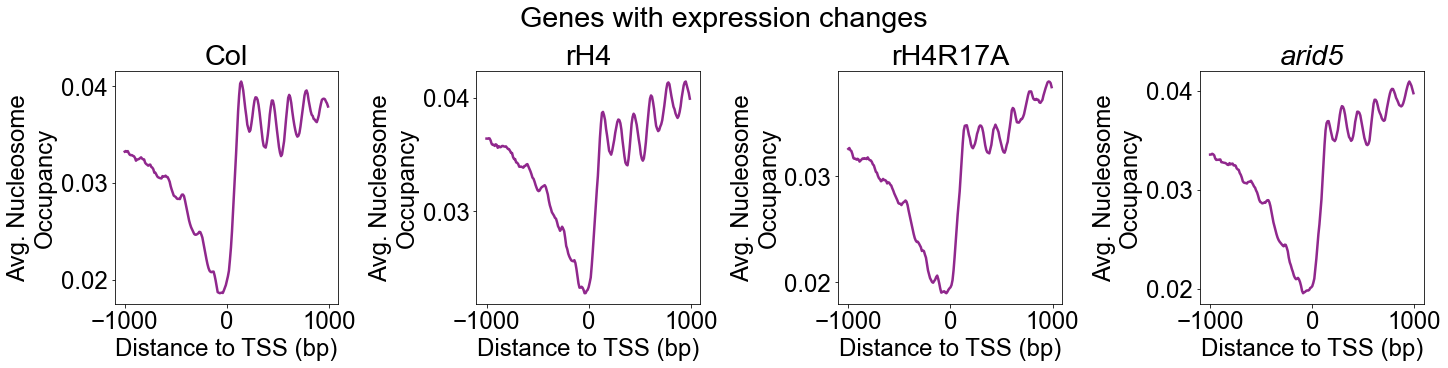

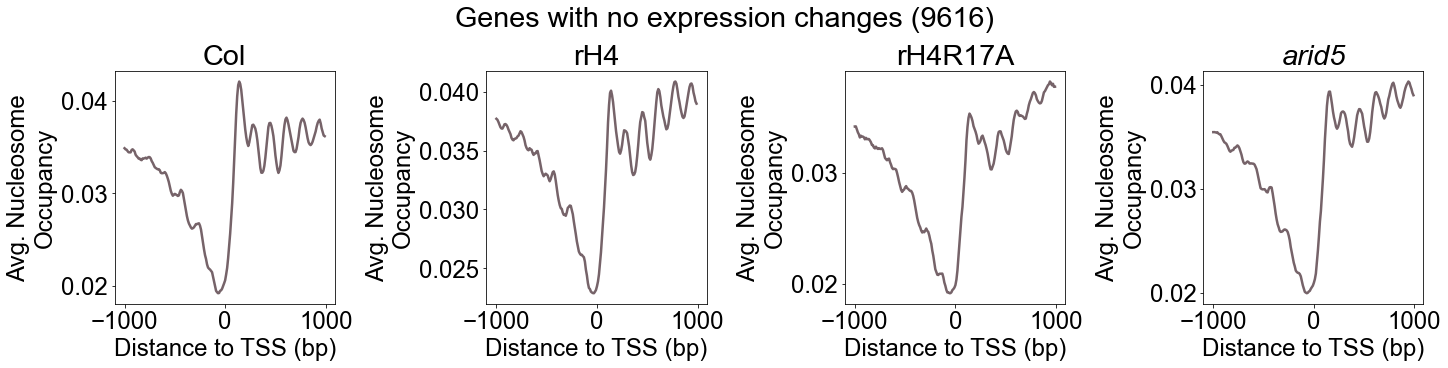

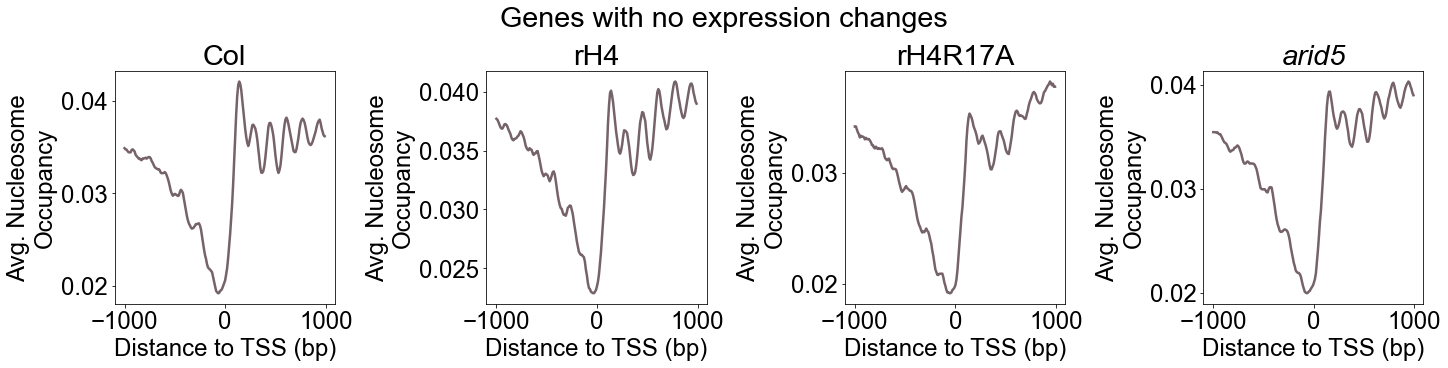

In [36]:
plot_gene_group_exp2(iswi_deg_subset, "Genes with expression changes", "#90288d", deg=False)
plot_gene_group_exp2(iswi_unaffected_subset, "Genes with no expression changes", "#766369", deg=False)

<ipython-input-35-af850631b76c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)
<ipython-input-35-af850631b76c>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 4, constrained_layout=True)
<ipython-input-35-af850631b76c>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam

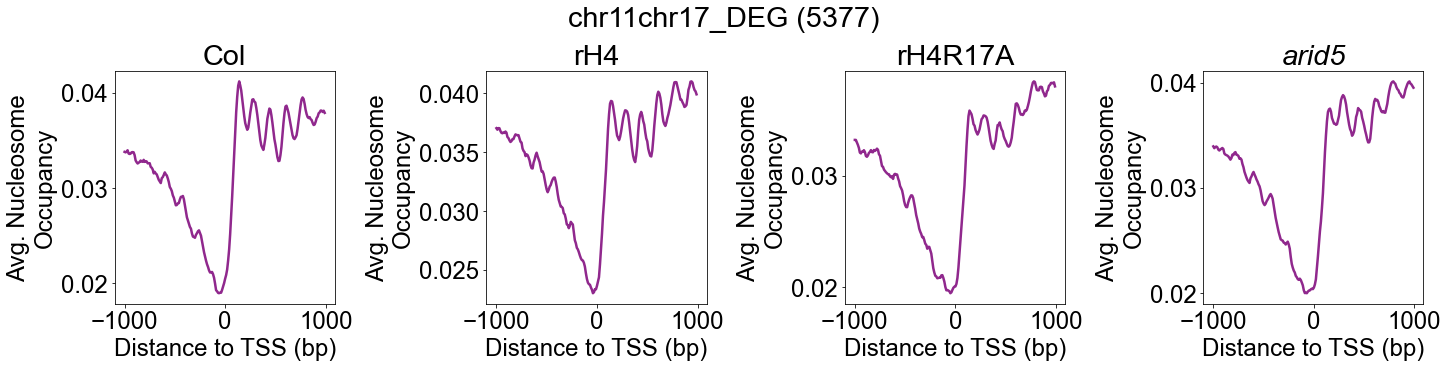

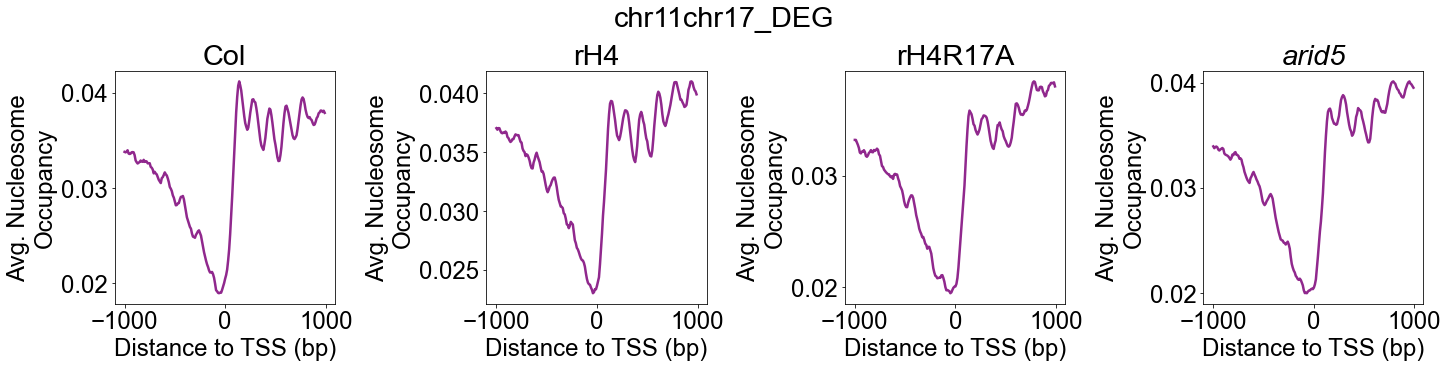

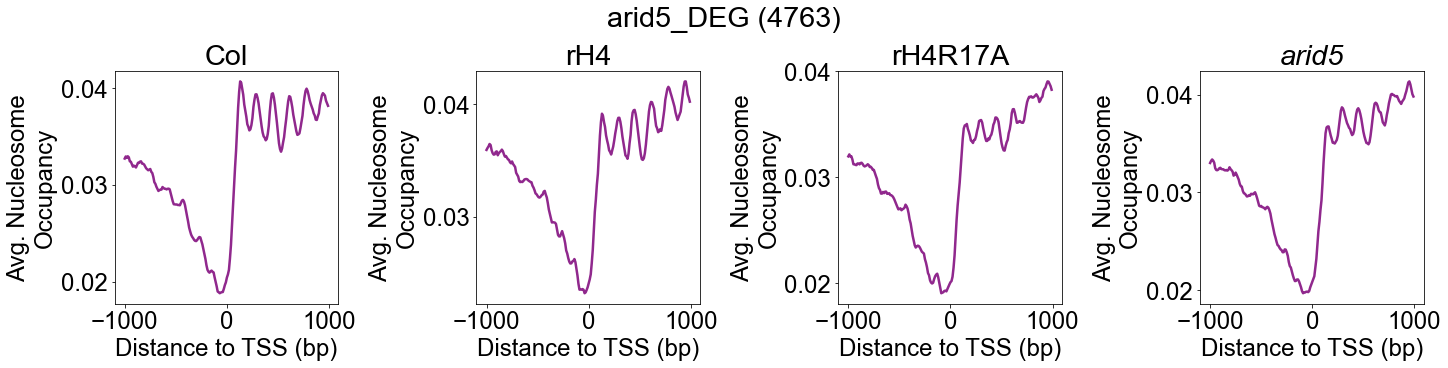

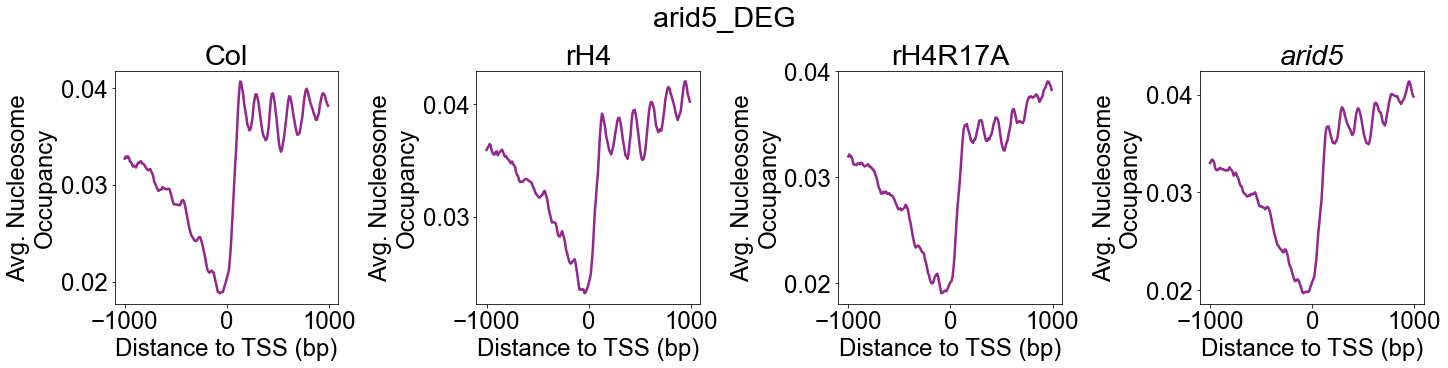

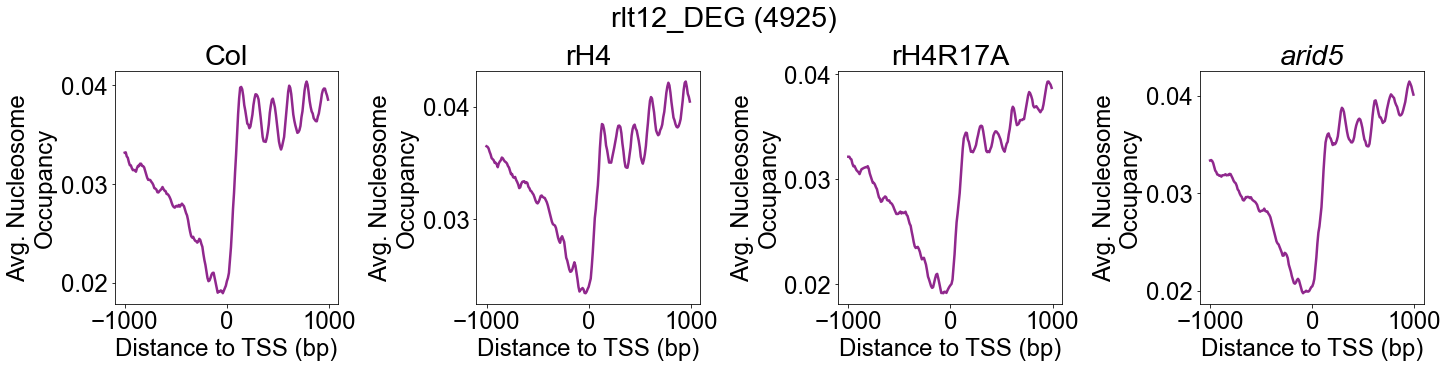

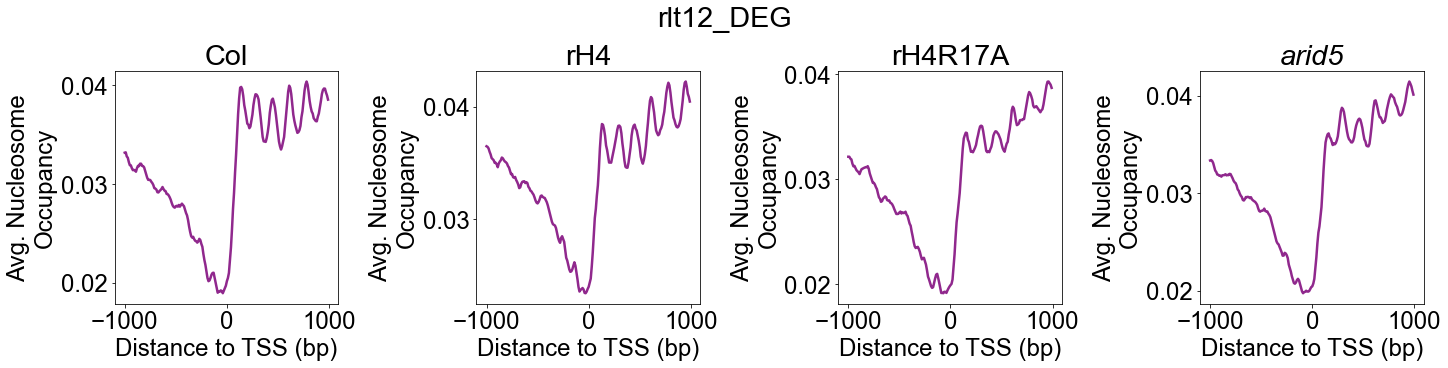

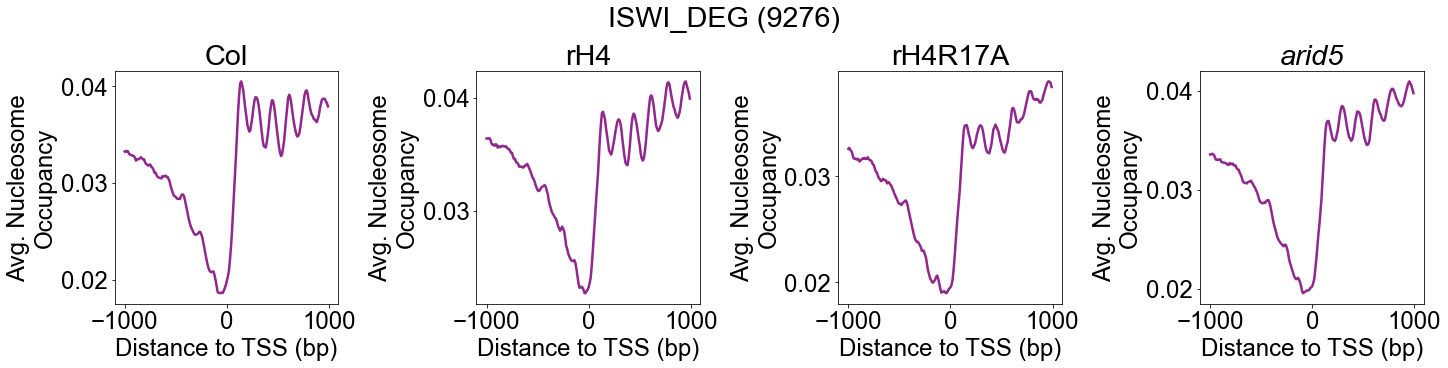

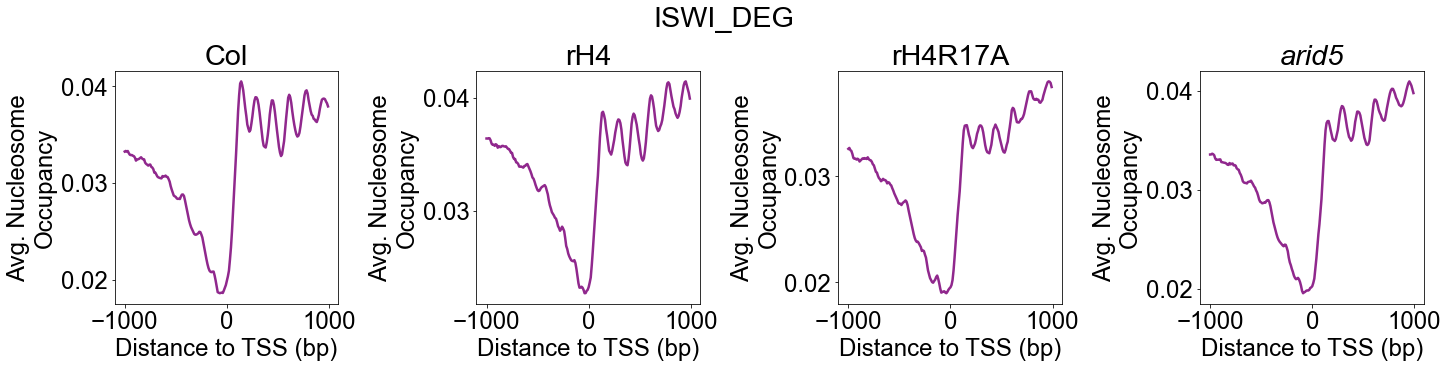

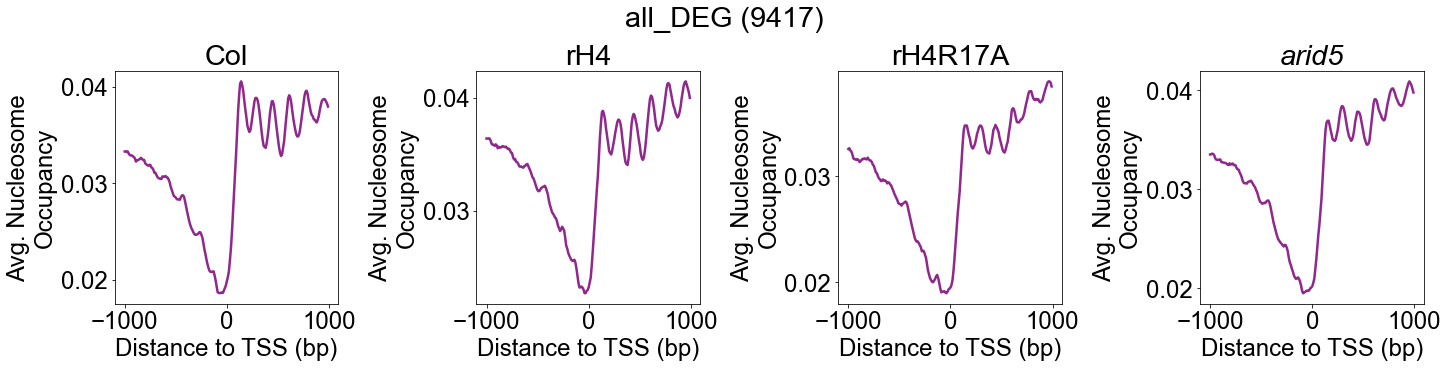

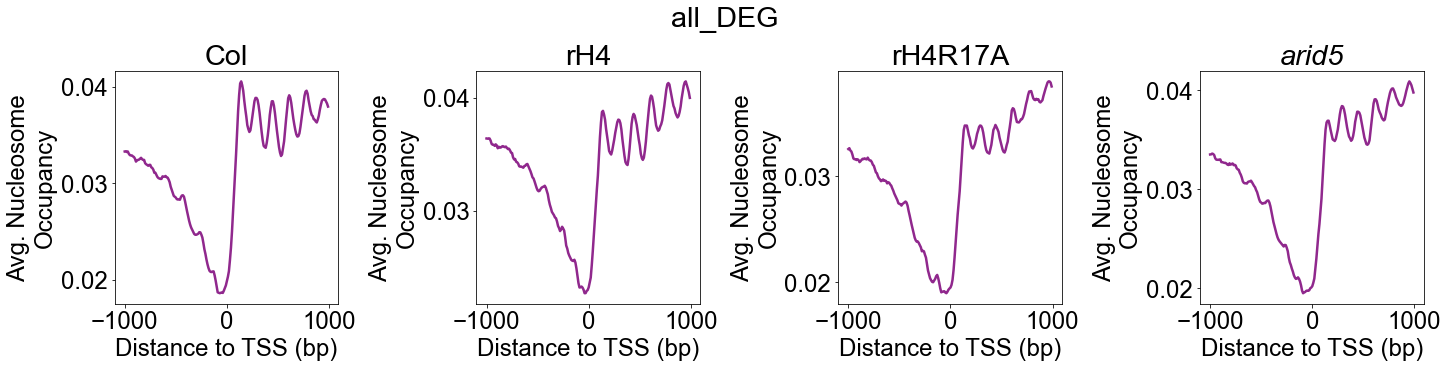

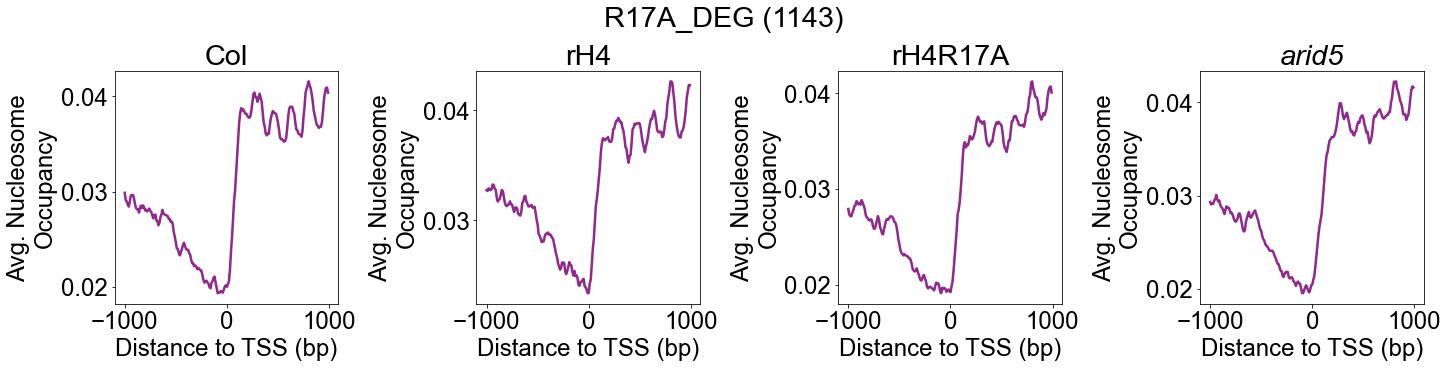

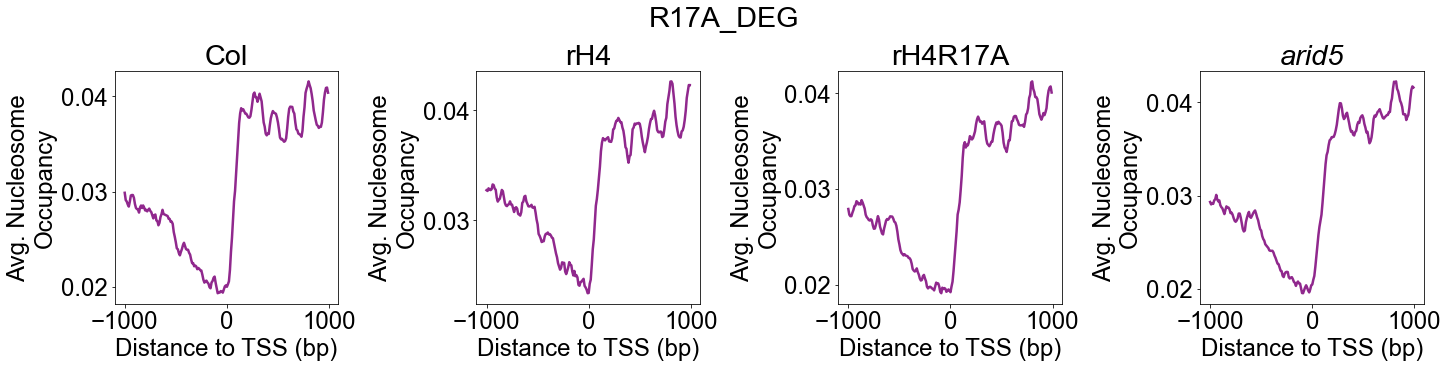

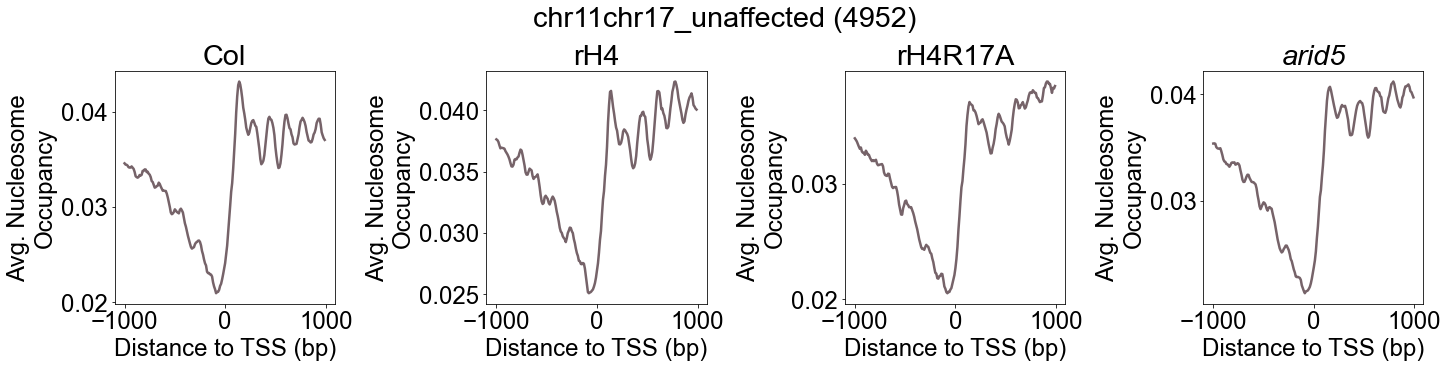

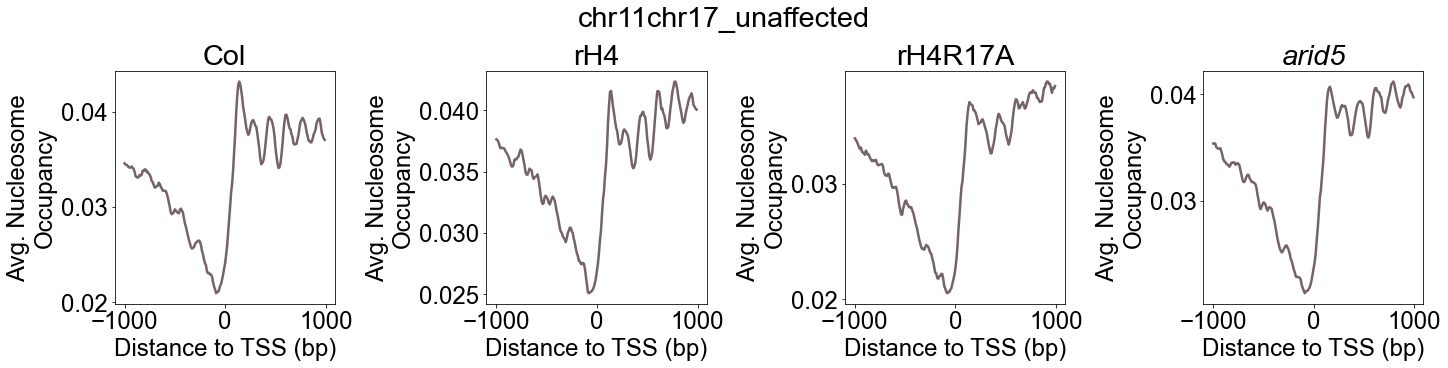

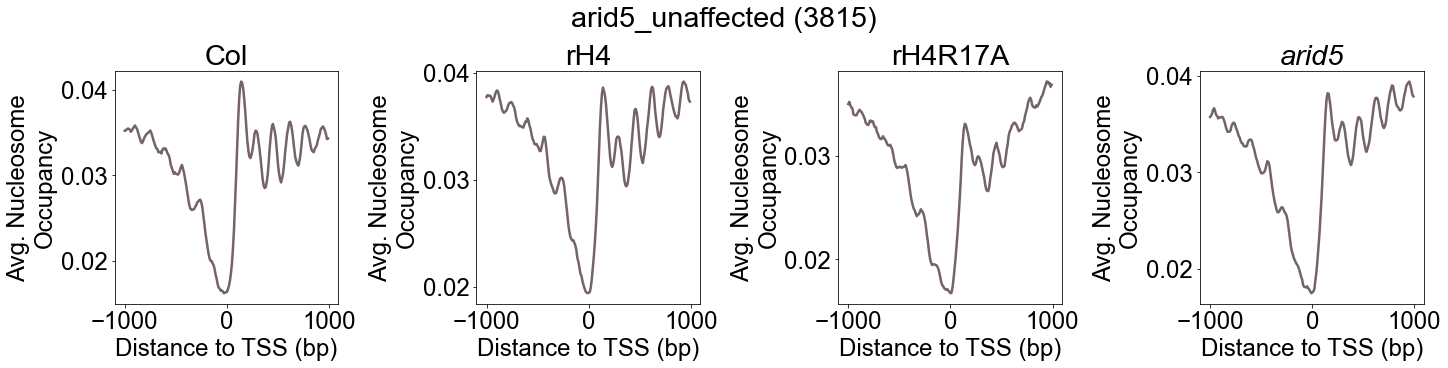

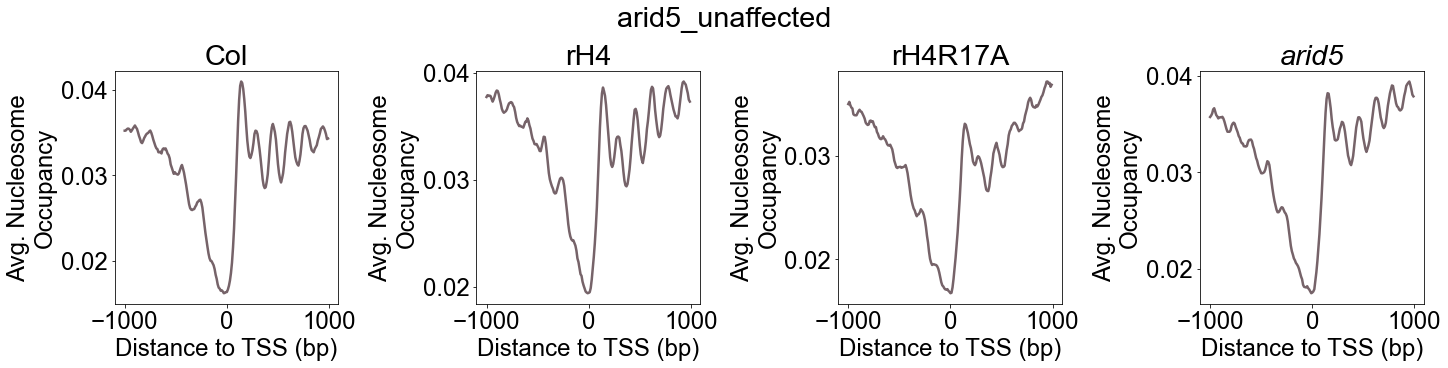

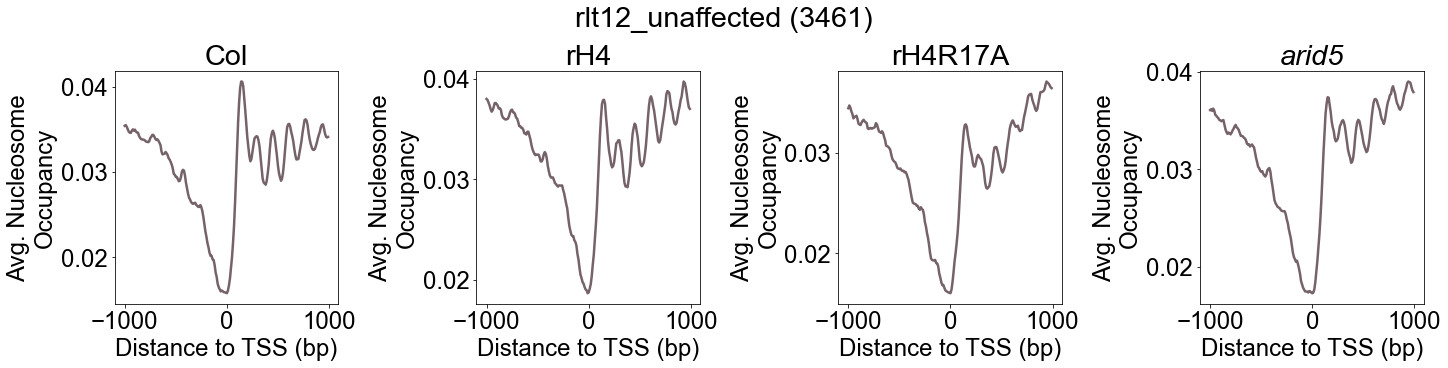

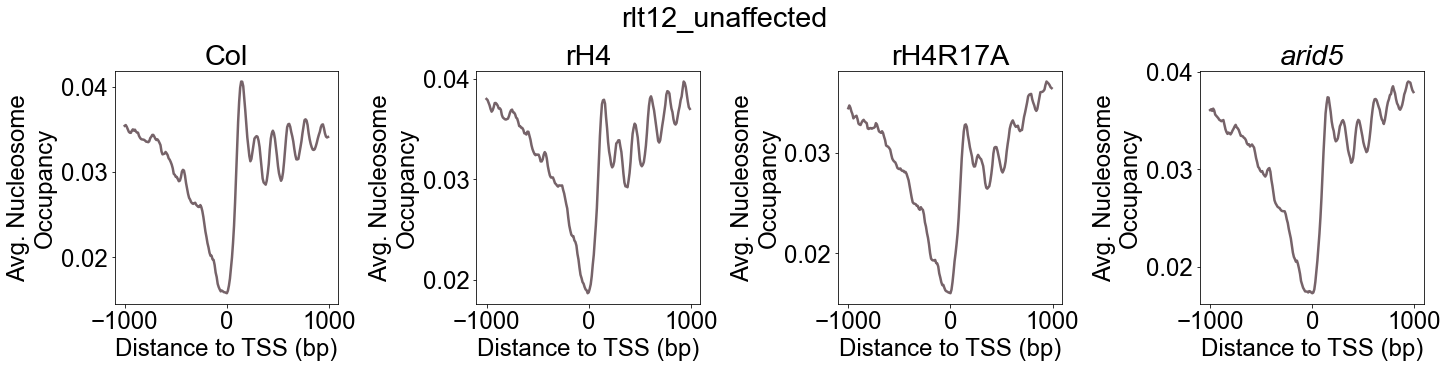

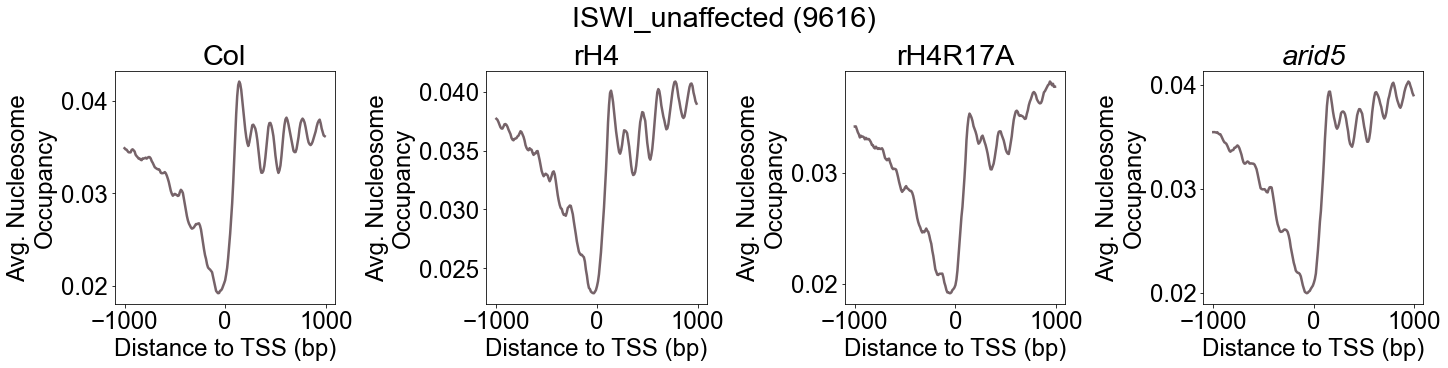

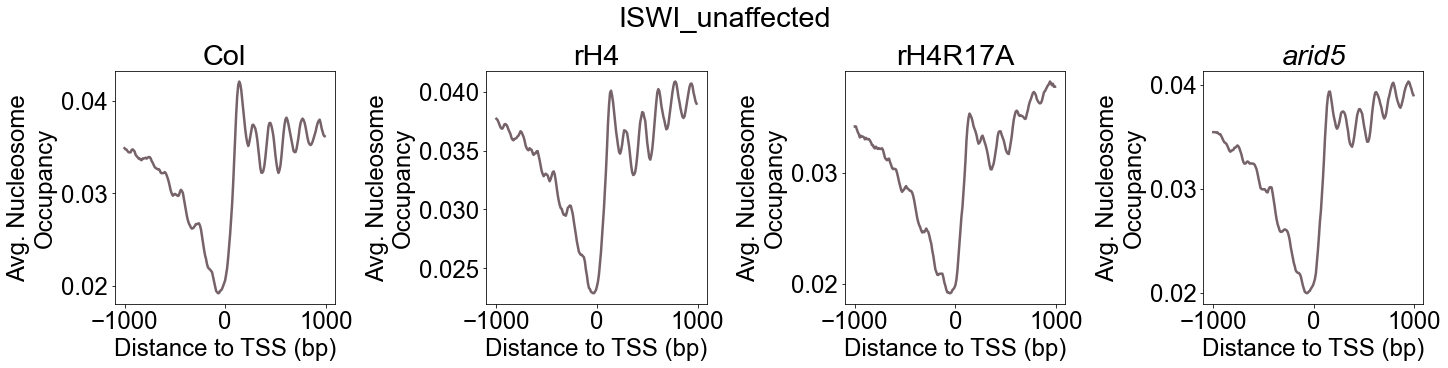

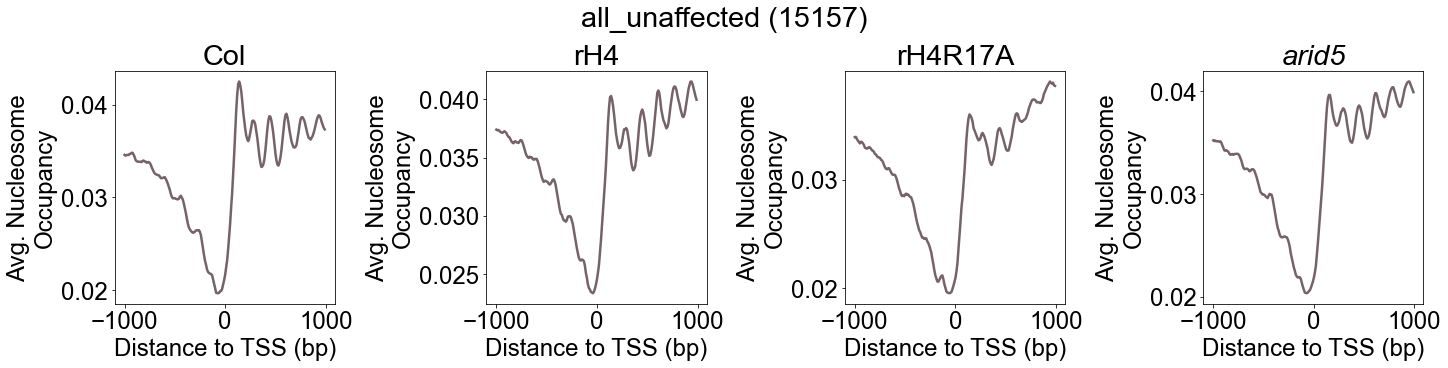

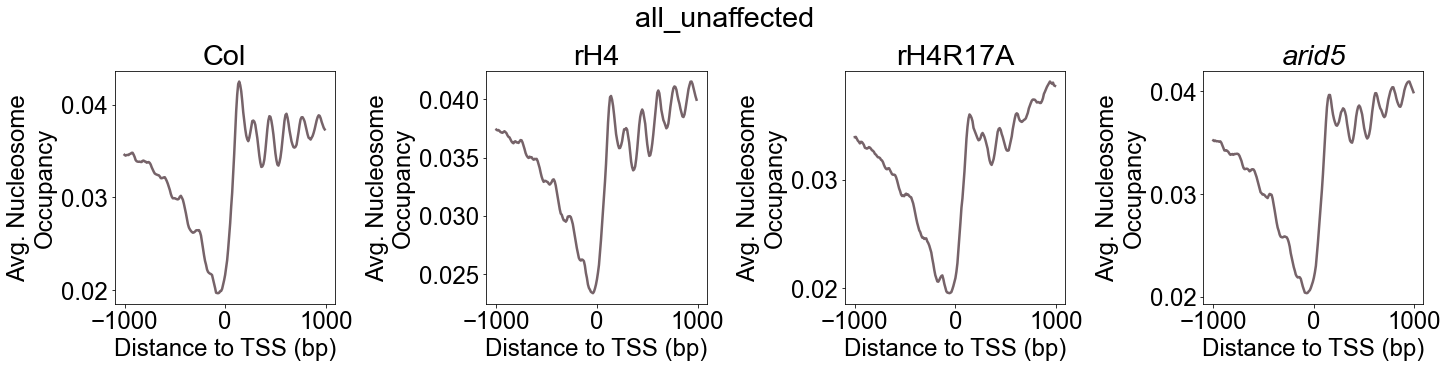

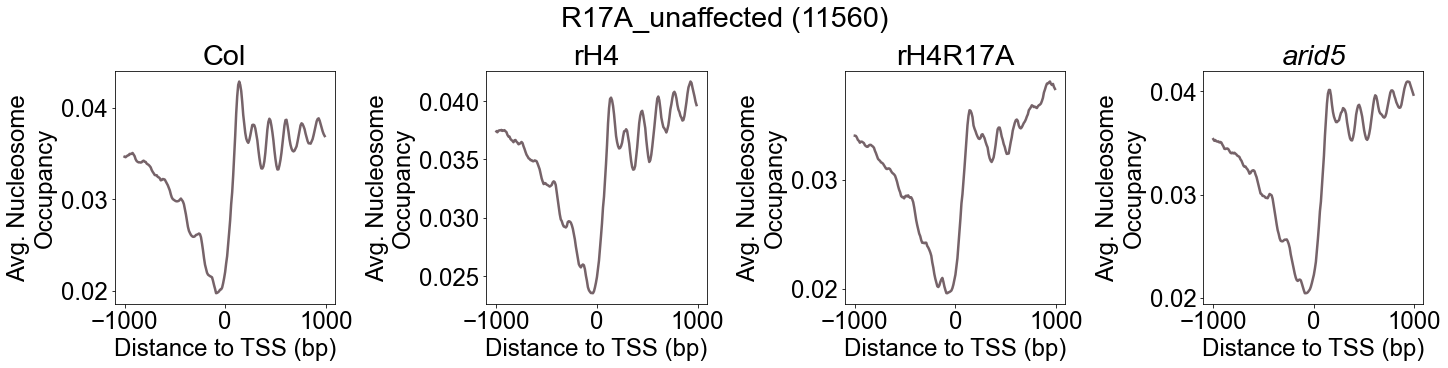

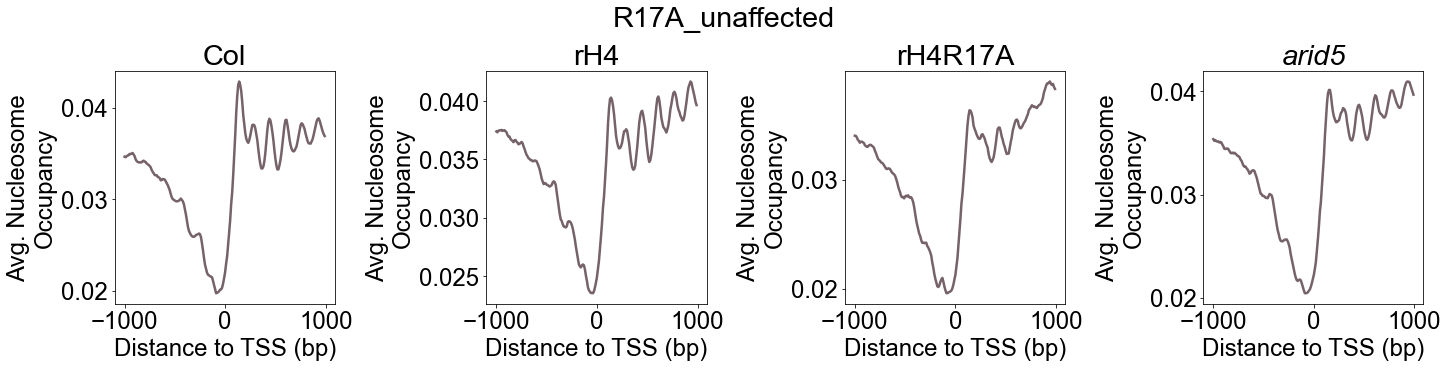

In [37]:
#Plot experiment 2 data
plot_gene_group_exp2(chr_deg_subset, "chr11chr17_DEG", "#90288d")
plot_gene_group_exp2(arid5_deg_subset, "arid5_DEG", "#90288d")
plot_gene_group_exp2(rlt12_deg_subset, "rlt12_DEG", "#90288d")
plot_gene_group_exp2(iswi_deg_subset, "ISWI_DEG", "#90288d", deg=False)

plot_gene_group_exp2(all_deg_subset, "all_DEG", "#90288d", deg=False)
plot_gene_group_exp2(x13_deg_subset, "R17A_DEG", "#90288d", deg=False)

plot_gene_group_exp2(chr_unaffected_subset, "chr11chr17_unaffected", "#766369", deg=False)
plot_gene_group_exp2(arid5_unaffected_subset, "arid5_unaffected", "#766369", deg=False)
plot_gene_group_exp2(rlt12_unaffected_subset, "rlt12_unaffected", "#766369", deg=False)

plot_gene_group_exp2(iswi_unaffected_subset, "ISWI_unaffected", "#766369", deg=False)
plot_gene_group_exp2(all_unaffected_subset, "all_unaffected", "#766369", deg=False)
plot_gene_group_exp2(x13_unaffected_subset, "R17A_unaffected", "#766369", deg=False)